______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [1]:
# pip install 'dtreeviz'

In [2]:
# pip install 'geopandas'

In [3]:
#Importación de librerías
import dtreeviz.trees as dtreeviz

import numpy as np
import cmath as math

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mticker
import pandas as pd
import geopandas as gpd

import seaborn as sns

import scipy as sc

import sklearn as sk
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor


#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Ejecución con Drive
# from google.colab import drive
# drive.mount('/content/drive')
# properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')
properati=pd.read_csv('properati_argentina_2021.csv')

#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**


Como se indica inicialmente en el enunciado del trabajo práctico, prodecemos a hacer una división de nuestro data set con el cual vamos a trabajar. 

Lo que haremos será definir un 80% del mismo como el conjunto de entrenamiento, y el 20% restante lo usaremos para poder testear nuevos valores.

In [4]:
df_original = properati.copy()
df = df_original.sample(frac=0.8, random_state=200) # este sera nuestro data set train!
test = df_original.drop(df.index)

A continuación se realizará un análisis general de cada una de las variables presentes en el dataframe.

In [5]:
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [6]:
df.head()

id  start_date    end_date  created_on  \
160116  JWtrhLm/BULQ5NeyL9xoqA==  2021-07-14  2021-08-21  2021-07-14   
92828   1gMQ4rXcpnPs+hhvW11Jdw==  2021-08-03  2021-10-28  2021-08-03   
327725  olHo7dLW4pHQnVQhAuv6/Q==  2021-12-14  2022-01-27  2021-12-14   
366457  GWMhOXhNCdPicnYbmZpT3w==  2021-04-10  2021-06-05  2021-04-10   
19975   p7gmyqzdOy/+odHwH5oPyg==  2021-01-27  2021-06-05  2021-01-27   

          latitud   longitud                place_l2       place_l3 place_l4  \
160116 -34.597419 -58.403760         Capital Federal       Recoleta      NaN   
92828  -34.622385 -58.448886         Capital Federal      Caballito      NaN   
327725        NaN        NaN  Bs.As. G.B.A. Zona Sur       La Plata      NaN   
366457        NaN        NaN  Bs.As. G.B.A. Zona Sur       La Plata      NaN   
19975  -34.618084 -58.359912         Capital Federal  Puerto Madero      NaN   

       place_l5  place_l6 operation    property_type  property_rooms  \
160116      NaN       NaN     Venta     Departamento             1.0   
92828       NaN       NaN     Venta     Departamento             4.0   
327725      NaN       NaN     Venta  Local comercial            10.0   
366457      NaN       NaN     Venta             Casa             3.0   
19975       NaN       NaN     Venta     Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
160116                1.0                    41.0                      37.0   
92828                 3.0                   113.0                      97.0   
327725                NaN                   230.0                     230.0   
366457                2.0                     NaN                     190.0   
19975                 1.0                    70.0                      65.0   

        property_price property_currency  \
160116             NaN               NaN   
92828         288000.0               USD   
327725        250000.0               USD   
366457        300000.0               USD   
19975         450000.0               USD   

                                           property_title  
160116  Excelente monoambiente con balcón Apto profesi...  
92828   Vta. Dpto. 4amb, Caballito, balcón aterrazado ...  
327725                                   Local - La Plata  
366457                           Casa - Campos de Roca II  
19975           Departamento con Cochera en Puerto Madero

### Preparación de los datasets

---

Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [7]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])
df.drop("operation", inplace=True, axis=1)
df.drop("property_currency", inplace=True, axis=1)
df.drop("property_title", inplace=True, axis=1)
train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price']

### Descripción de Campos

---

`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

---

Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [8]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

latitud   longitud  place_l5  place_l6  property_rooms  \
mean   -34.591075 -58.450048       NaN       NaN        2.825187   
25%    -34.616003 -58.466547       NaN       NaN        2.000000   
75%    -34.577374 -58.408848       NaN       NaN        4.000000   
std      0.189427   0.291986       NaN       NaN        1.423749   
median -34.595763 -58.438998       NaN       NaN        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
mean             2.018113              111.456956                 89.927611   
25%              1.000000               45.000000                 40.000000   
75%              3.000000              105.000000                 89.000000   
std              1.134732             1070.905984               1103.238289   
median           2.000000               65.000000                 58.000000   

        property_price  
mean     226180.465073  
25%       95000.000000  
75%      238000.000000  
std      308885.375804  
median   144000.000000

### Variables Cualitativas: Cantidades y Frecuencias

---

Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [9]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


<AxesSubplot: >

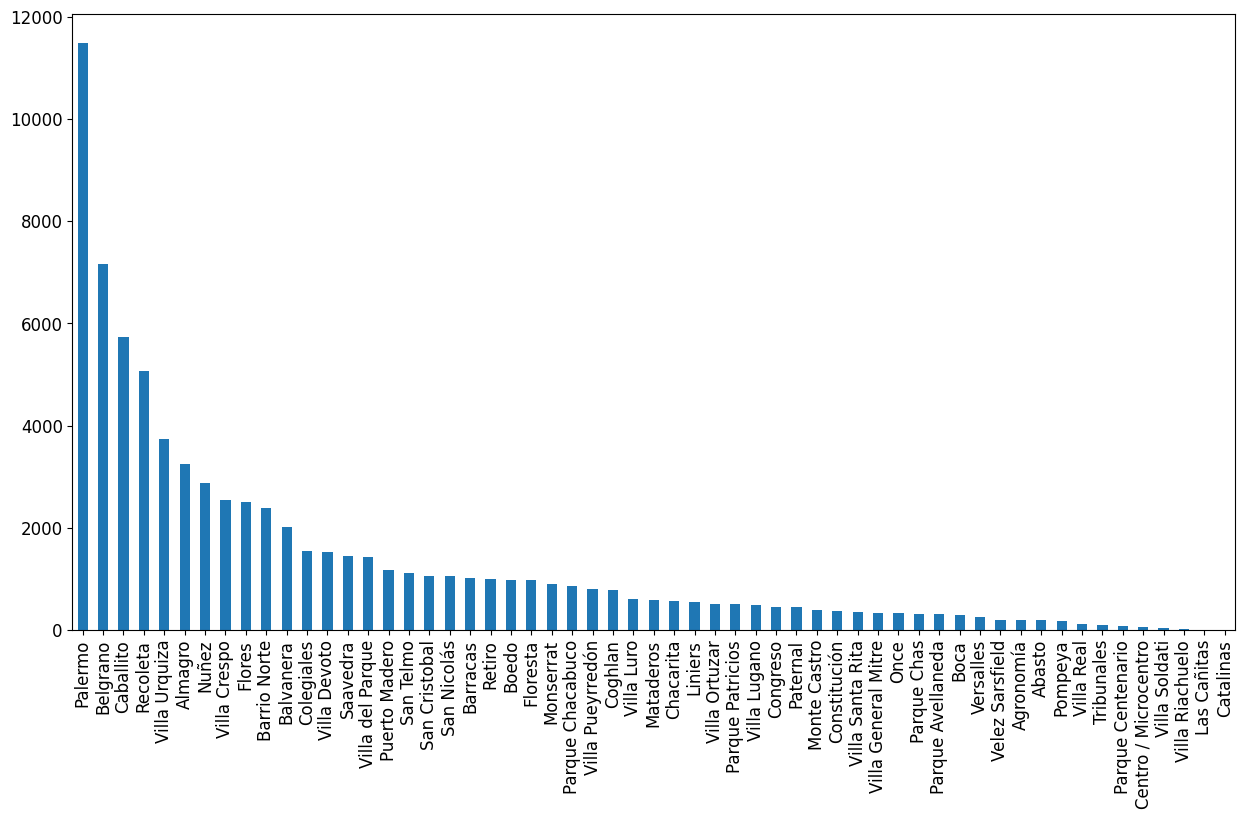

In [10]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [11]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


<AxesSubplot: >

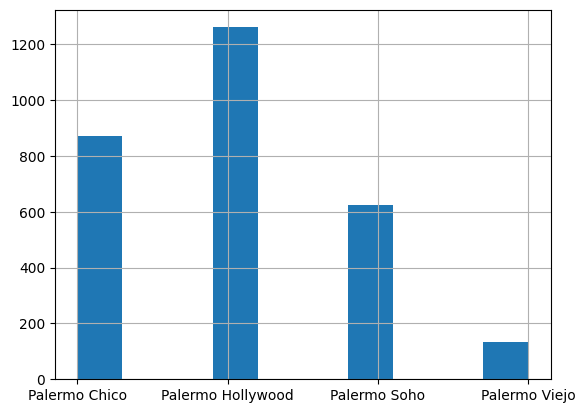

In [12]:
df['place_l4'].hist()

<AxesSubplot: >

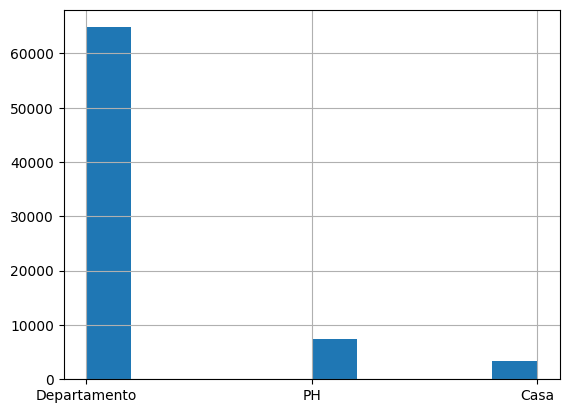

In [13]:
df['property_type'].hist()

In [14]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

---

Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

---



#### Densidad de la variable `latitud`

<AxesSubplot: xlabel='latitud', ylabel='Density'>

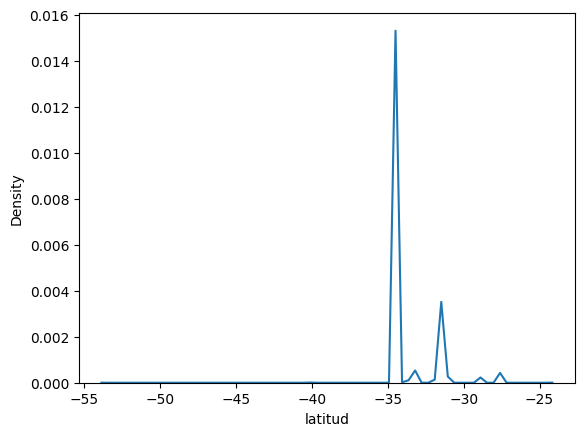

In [15]:
sns.kdeplot(data=df.latitud, gridsize=70)

#### Densidad de la variable `longitud`

<AxesSubplot: xlabel='longitud', ylabel='Density'>

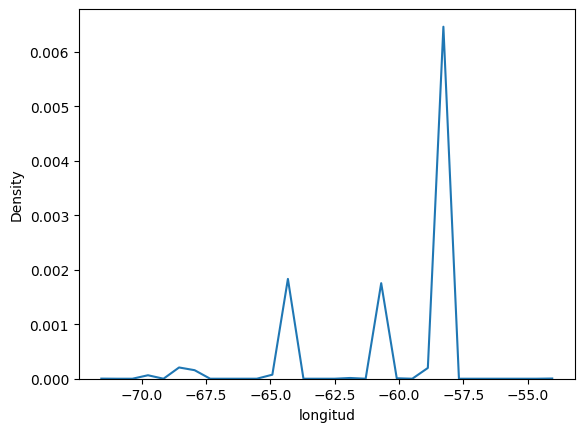

In [16]:
sns.kdeplot(data=df.longitud, gridsize=30)


#### Densidad de la variable `property_price`

<AxesSubplot: xlabel='property_price', ylabel='Density'>

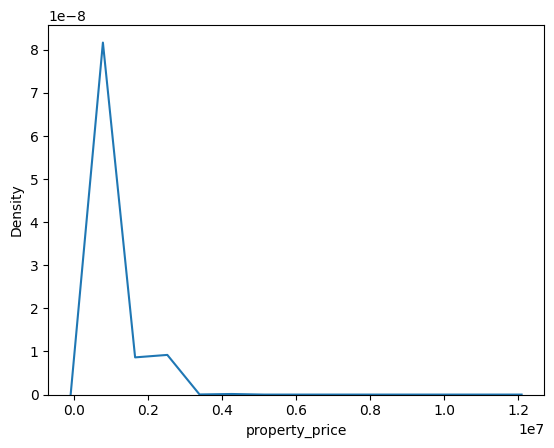

In [17]:
sns.kdeplot(data=df.property_price, gridsize=15)


#### Densidad de la variable `property_rooms`

<AxesSubplot: xlabel='property_rooms', ylabel='count'>

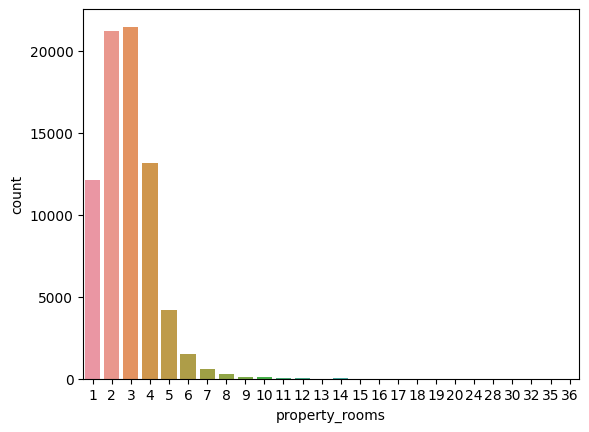

In [18]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

#### Densidad de la variable `property_surface_covered`

<AxesSubplot: xlabel='property_surface_covered', ylabel='Density'>

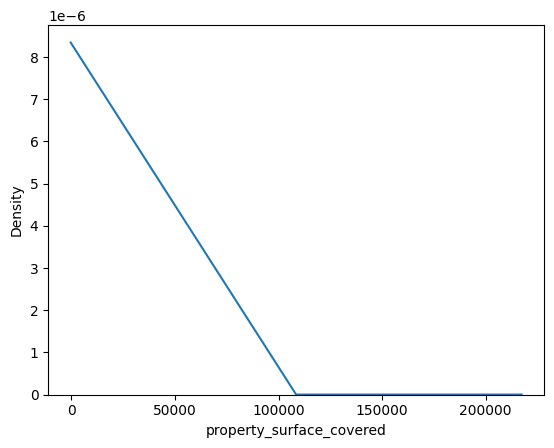

In [19]:
sns.kdeplot(data=df.property_surface_covered, gridsize=3)


### Análisis de las Correlaciones existentes entre las Variables

---

In [20]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [21]:
columns = df.columns.tolist()
df_pariplot = df[columns].copy()
# graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

### Conclusiones
----

## **1b. Datos Faltantes**

A continuación se realizara un análisis sobre los datos faltantes del dataframe.

Creamos una copia del dataset hasta el momento para comparar más adelante.

In [22]:
df_copy = df.copy()

### Análisis a Nivel Columna

---



Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

<AxesSubplot: >

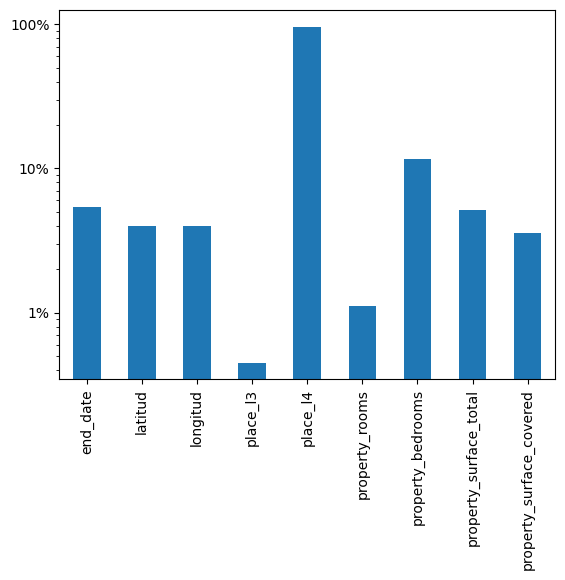

In [23]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

---



Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

<AxesSubplot: >

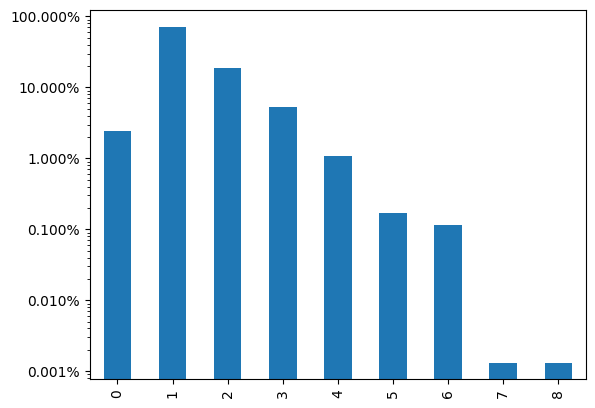

In [24]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

---



A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [25]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

<AxesSubplot: >

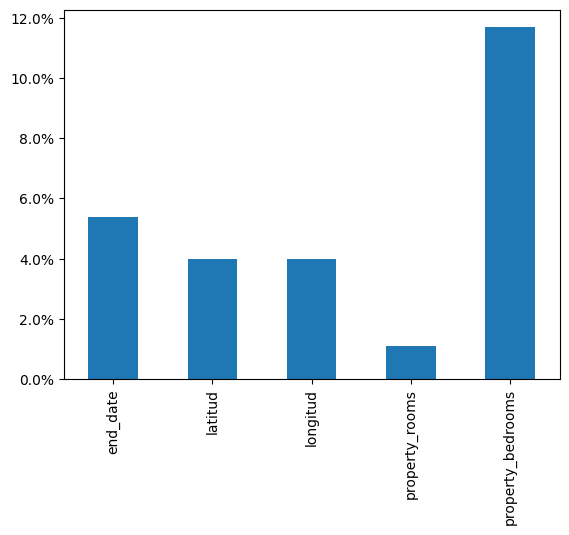

In [26]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

Reemplazamos la cantidad de habitaciones no definidos por la media calculada filtrando por cantidad total de dormitorios.

In [27]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)

Para eliminar los últimos valores nulos en las columnas de habitaciones, lo completamos con una regresión en funcion de la superficie cubierta

In [28]:
from sklearn.linear_model import LinearRegression
df_train = df.loc[df['property_rooms'].notna()]
reg = LinearRegression().fit(np.array(df_train['property_surface_covered']).reshape(-1, 1), df_train['property_rooms'])

In [29]:
df_topredict = df.loc[df['property_rooms'].isna()]['property_surface_covered']
df['property_rooms'] = df.apply(lambda x: round(reg.predict([[x.property_surface_covered]])[0]) if pd.isna(x.property_rooms) else x.property_rooms, axis=1)

Luego reemplazamos la cantidad total de dormitorios no definidas por la media calculada filtrando por cantidad de habitaciones.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

<AxesSubplot: >

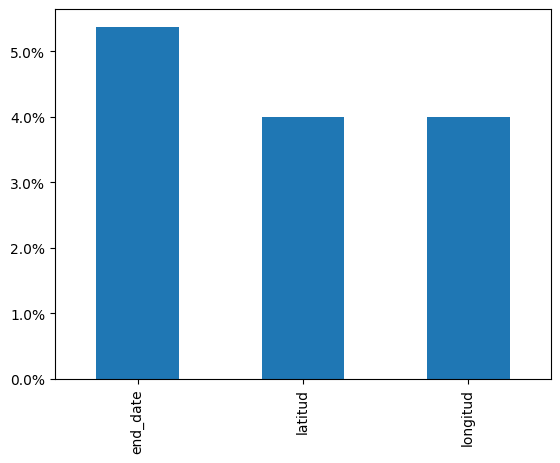

In [30]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[df['property_rooms'] == i].property_bedrooms.median()
    if pd.isna(median):
        median = df.loc[df['property_rooms'] == i]['property_rooms'].iloc[0]
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)

# df['property_bedrooms'] = df['property_bedrooms'].replace(np.nan, 0)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

In [31]:
df["property_bedrooms"].isnull().sum()
df.loc[df["property_bedrooms"].isnull() == True]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [32]:
df["property_bedrooms"].isna().sum()

0

<AxesSubplot: ylabel='Density'>

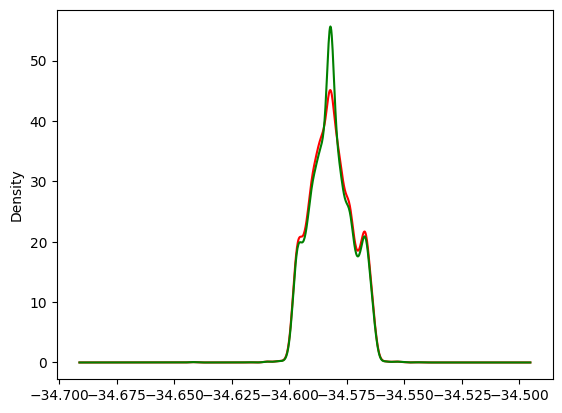

In [33]:
df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    lat_median = df.loc[(df["place_l4"] == barrio) & (df['latitud'].notna()) ].latitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"] = df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"].fillna(lat_median)

df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "green")

<AxesSubplot: ylabel='Density'>

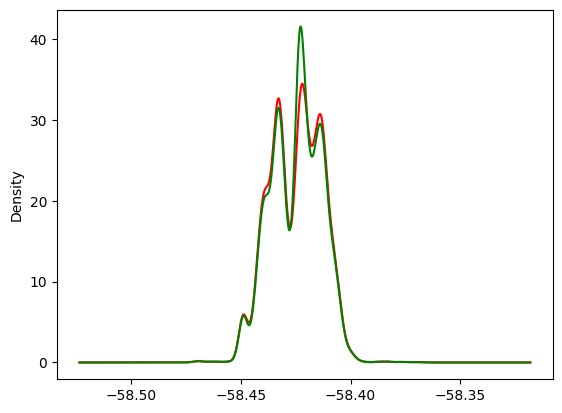

In [34]:
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    long_median = df.loc[(df["place_l4"] == barrio) & (df['longitud'].notna())].longitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"] = df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"].fillna(long_median)
    
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "green")

<AxesSubplot: >

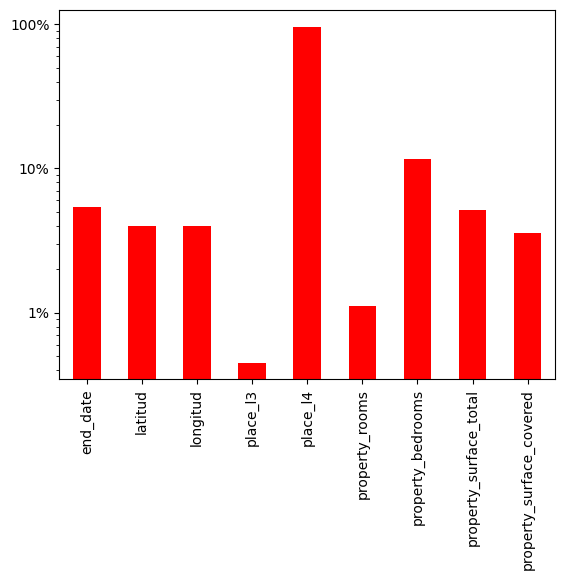

In [35]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df_copy.isnull().sum() * 100 / len(df_copy)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="red", zorder=0)

<AxesSubplot: >

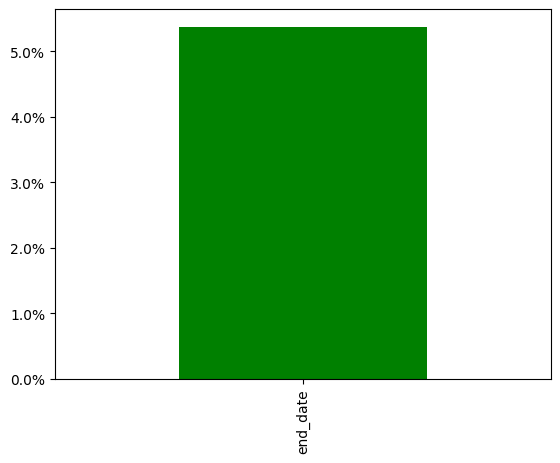

In [36]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="green", zorder=1)

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe. En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).

### Outliers univariados

---

Para el análisis de outliers de tipo univariados estaremos utilizando tanto el método de Box Plot como los métodos de Z-Score y Z-Score Modificado.

Mientras que el primero nos brindará información respecto de los topes superiores e inferiores de los cuartiles Q3 y Q1 respectivamente, los gráficos de Z-Score y Z-Score modificado nos permitirán visualizar de forma eficiente cómo se distribuye la masa de observaciones respecto de la media, y -por tanto- poder determinar de forma más precisa cuáles son los valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Property rooms

##### Box plot

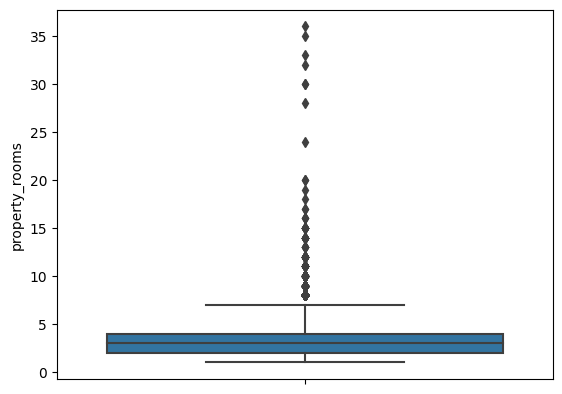

In [37]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [38]:
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


##### Z-Score

In [39]:
media_rooms=np.mean(df.property_rooms)
std_rooms=np.std(df.property_rooms)
df['z_rooms']=(df.property_rooms - media_rooms)/std_rooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [40]:
df[df['z_rooms']>3].head()

id start_date   end_date created_on    latitud  \
403885  N/jyCx+vnAxpsyxmCuU4xg== 2021-08-13 2022-01-27 2021-08-13 -34.621092   
307513  dAAEvt8ZmDRkeI0RUhc8LQ== 2021-01-28 2021-06-01 2021-01-28 -34.557276   
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24 2021-06-05 2021-03-24 -34.642037   
183036  UadoQu8km6lqyFrDgGL6JQ== 2021-12-21 2022-01-27 2021-12-21 -34.602550   
275967  Klyis7WaldWj5vYfzv26KA== 2021-12-23 2022-01-27 2021-12-23 -34.612030   

         longitud         place_l2          place_l3          place_l4  \
403885 -58.376189  Capital Federal         San Telmo         San Telmo   
307513 -58.494583  Capital Federal          Saavedra          Saavedra   
150885 -58.438995  Capital Federal  Parque Chacabuco  Parque Chacabuco   
183036 -58.459456  Capital Federal          Paternal          Paternal   
275967 -58.415660  Capital Federal           Almagro           Almagro   

       property_type  property_rooms  property_bedrooms  \
403885          Casa             8.0                6.0   
307513          Casa             8.0                5.0   
150885  Departamento            35.0               35.0   
183036          Casa             8.0                4.0   
275967            PH            12.0                8.0   

        property_surface_total  property_surface_covered  property_price  \
403885                   511.0                     511.0        790000.0   
307513                   377.0                     377.0        480000.0   
150885                    37.0                      33.0         67000.0   
183036                   329.0                     329.0        240000.0   
275967                   315.0                     230.0        399000.0   

          z_rooms  
403885   3.602309  
307513   3.602309  
150885  22.435777  
183036   3.602309  
275967   6.392453

In [41]:
df[df['z_rooms']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms]
Index: []

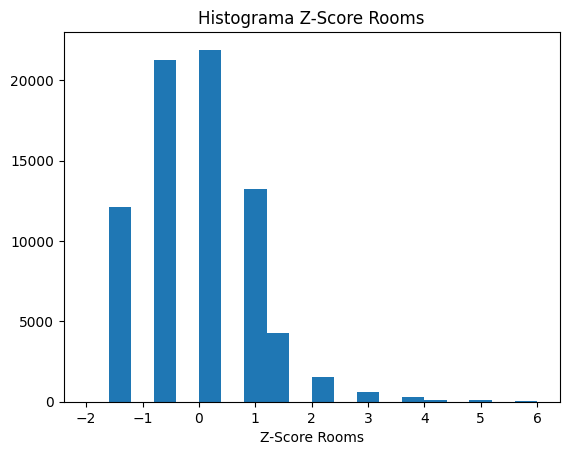

In [42]:
plt.hist(df.z_rooms, bins=20, range=(-2,6))
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Z-Score Modificado

In [43]:
mediana_room=np.nanmedian(df.property_rooms)

MAD=np.nanmedian(np.absolute(df.property_rooms-mediana_room))

df['zm_rooms']=(df.property_rooms - mediana_room)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [44]:
df[(df['zm_rooms']>3.5)].head()

id start_date   end_date created_on    latitud  \
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24 2021-06-05 2021-03-24 -34.642037   
275967  Klyis7WaldWj5vYfzv26KA== 2021-12-23 2022-01-27 2021-12-23 -34.612030   
80591   t48KQIS/LPKnOIPAiuWgpw== 2021-08-17 2021-12-30 2021-08-17 -34.590172   
152772  pzvOVs/NpbhfcVRAY7wzLg== 2021-12-09 2022-01-27 2021-12-09 -34.624860   
203421  GeIgQWvogHzgvQvb12534g== 2021-05-10 2021-06-05 2021-05-10 -34.584499   

         longitud         place_l2          place_l3           place_l4  \
150885 -58.438995  Capital Federal  Parque Chacabuco   Parque Chacabuco   
275967 -58.415660  Capital Federal           Almagro            Almagro   
80591  -58.385131  Capital Federal          Recoleta           Recoleta   
152772 -58.421026  Capital Federal           Almagro            Almagro   
203421 -58.439725  Capital Federal           Palermo  Palermo Hollywood   

       property_type  property_rooms  property_bedrooms  \
150885  Departamento            35.0               35.0   
275967            PH            12.0                8.0   
80591   Departamento             9.0                5.0   
152772          Casa            10.0                5.0   
203421          Casa            10.0                4.0   

        property_surface_total  property_surface_covered  property_price  \
150885                    37.0                      33.0         67000.0   
275967                   315.0                     230.0        399000.0   
80591                    335.0                     310.0        850000.0   
152772                   400.0                     350.0        570000.0   
203421                   560.0                     362.0       1350000.0   

          z_rooms  zm_rooms  
150885  22.435777   21.5840  
275967   6.392453    6.0705  
80591    4.299845    4.0470  
152772   4.997381    4.7215  
203421   4.997381    4.7215

In [45]:
df[(df['zm_rooms']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms]
Index: []

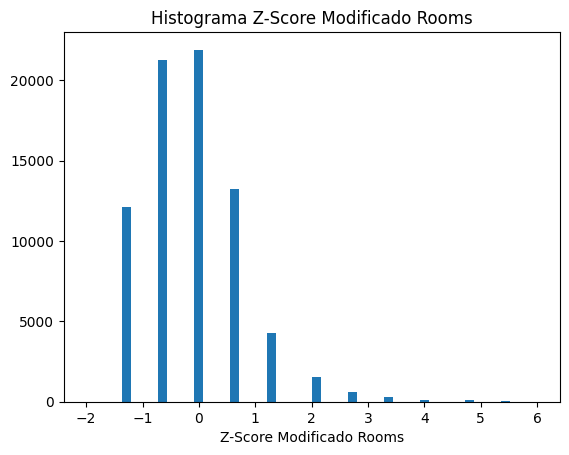

In [46]:
plt.hist(df.zm_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('Z-Score Modificado Rooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones que superan el límite superior del tercer cuartil, podríamos decir que los outliers en cuestión son del tipo colectivo.

#### Property bedrooms

 ##### Box plot


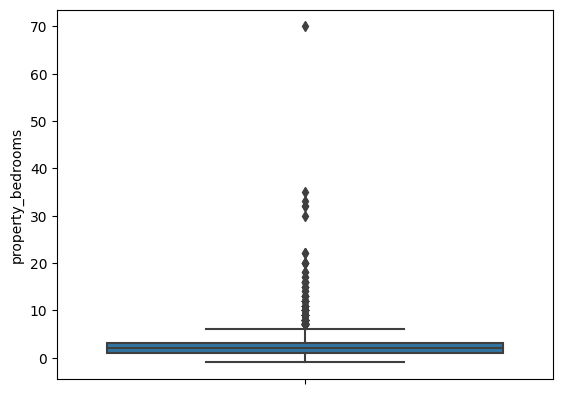

In [47]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [48]:
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


##### Z-Score

In [49]:
media_bedrooms=np.mean(df.property_bedrooms)
std_bedrooms=np.std(df.property_bedrooms)
df['z_bedrooms']=(df.property_bedrooms - media_bedrooms)/std_bedrooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [50]:
df[df['z_bedrooms']>3].head()

id start_date   end_date created_on    latitud  \
403885  N/jyCx+vnAxpsyxmCuU4xg== 2021-08-13 2022-01-27 2021-08-13 -34.621092   
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24 2021-06-05 2021-03-24 -34.642037   
204107  AN09t0cj6CnyV9CYFqPsTg== 2021-05-10 2021-06-05 2021-05-10 -34.590275   
275967  Klyis7WaldWj5vYfzv26KA== 2021-12-23 2022-01-27 2021-12-23 -34.612030   
398724  t0mG+MlvoUEuQxyELQvmgg== 2021-02-13 2021-07-26 2021-02-13 -34.604668   

         longitud         place_l2          place_l3          place_l4  \
403885 -58.376189  Capital Federal         San Telmo         San Telmo   
150885 -58.438995  Capital Federal  Parque Chacabuco  Parque Chacabuco   
204107 -58.383917  Capital Federal          Recoleta          Recoleta   
275967 -58.415660  Capital Federal           Almagro           Almagro   
398724 -58.396573  Capital Federal         Balvanera         Balvanera   

       property_type  property_rooms  property_bedrooms  \
403885          Casa             8.0                6.0   
150885  Departamento            35.0               35.0   
204107  Departamento             6.0                6.0   
275967            PH            12.0                8.0   
398724  Departamento             8.0                7.0   

        property_surface_total  property_surface_covered  property_price  \
403885                   511.0                     511.0        790000.0   
150885                    37.0                      33.0         67000.0   
204107                   379.0                     379.0       1150000.0   
275967                   315.0                     230.0        399000.0   
398724                   247.0                     232.0        360000.0   

          z_rooms  zm_rooms  z_bedrooms  
403885   3.602309    3.3725    3.609858  
150885  22.435777   21.5840   29.245526  
204107   2.207238    2.0235    3.609858  
275967   6.392453    6.0705    5.377835  
398724   3.602309    3.3725    4.493846

In [51]:
df[df['z_bedrooms']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms]
Index: []

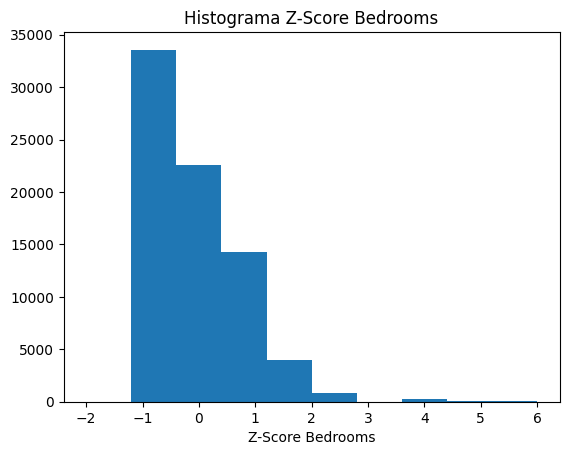

In [52]:
plt.hist(df.z_bedrooms, bins=10, range=(-2,6))
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Z-Score Modificado

In [53]:
mediana_bedroom=np.nanmedian(df.property_bedrooms)
MAD=np.nanmedian(np.absolute(df.property_bedrooms-mediana_bedroom))

df['zm_bedrooms']=(df.property_bedrooms - mediana_bedroom)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [54]:
df[(df['zm_bedrooms']>3.5)].head()

id start_date   end_date created_on    latitud  \
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24 2021-06-05 2021-03-24 -34.642037   
275967  Klyis7WaldWj5vYfzv26KA== 2021-12-23 2022-01-27 2021-12-23 -34.612030   
292167  CxZv3EmTnK+m6EJD2uQ5fw== 2021-02-23 2021-03-03 2021-02-23 -34.616487   
243306  kiPcWdndWrwZ4qvRC/PKWQ== 2021-02-11        NaT 2021-02-11 -34.573683   
282796  XzxA7BMZ8iavT0FyqFL2cg== 2021-09-16 2022-02-09 2021-09-16 -34.604522   

         longitud         place_l2          place_l3          place_l4  \
150885 -58.438995  Capital Federal  Parque Chacabuco  Parque Chacabuco   
275967 -58.415660  Capital Federal           Almagro           Almagro   
292167 -58.371596  Capital Federal         San Telmo         San Telmo   
243306 -58.470382  Capital Federal          Belgrano          Belgrano   
282796 -58.400579  Capital Federal         Balvanera         Balvanera   

       property_type  property_rooms  property_bedrooms  \
150885  Departamento            35.0               35.0   
275967            PH            12.0                8.0   
292167            PH            24.0               22.0   
243306          Casa            11.0                9.0   
282796  Departamento            10.0                9.0   

        property_surface_total  property_surface_covered  property_price  \
150885                    37.0                      33.0         67000.0   
275967                   315.0                     230.0        399000.0   
292167                   800.0                     650.0        350000.0   
243306                   537.0                     537.0       1120000.0   
282796                   294.0                     160.0        199000.0   

          z_rooms  zm_rooms  z_bedrooms  zm_bedrooms  
150885  22.435777   21.5840   29.245526      22.2585  
275967   6.392453    6.0705    5.377835       4.0470  
292167  14.762883   14.1645   17.753675      13.4900  
243306   5.694917    5.3960    6.261823       4.7215  
282796   4.997381    4.7215    6.261823       4.7215

In [55]:
df[(df['zm_bedrooms']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms]
Index: []

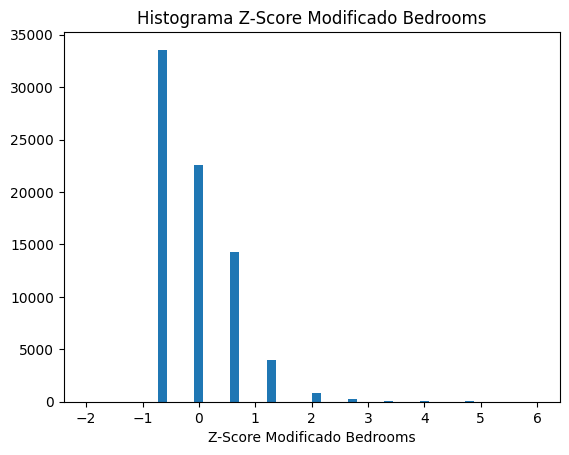

In [56]:
plt.hist(df.zm_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('Z-Score Modificado Bedrooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la singular por encima del resto de las observaciones).

#### Property price

##### Box plot

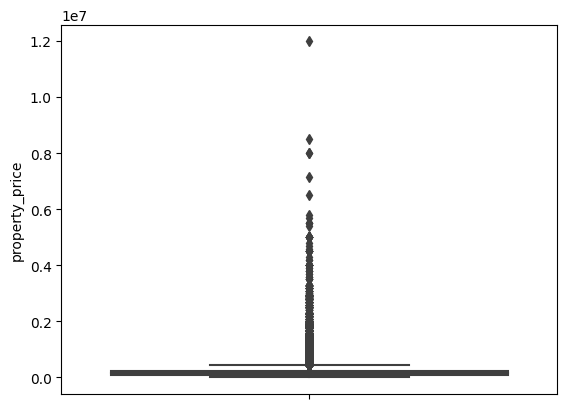

In [57]:
sns.boxplot(y=df.property_price)
plt.show()

In [58]:
Q1_property_price=df.describe().get("property_price").get("25%")
Q3_property_price=df.describe().get("property_price").get("75%")

print("El valor de Q1 es:", Q1_property_price)
print("El valor de Q3 es:", Q3_property_price)

IQR_property_price=Q3_property_price-Q1_property_price

out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 95000.0
El valor de Q3 es: 238000.0
El limite inferior del Q1 es: -119500.0
El limite superior del Q3 es: 452500.0


##### Z-Score

In [59]:
media_price=np.mean(df.property_price)
std_price=np.std(df.property_price)
df['z_price']=(df.property_price - media_price)/std_price

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [60]:
df[df['z_price']>3].head()

id start_date   end_date created_on    latitud  \
155779  7pcoT994dx5/Rf9Z3VtSow== 2021-04-05 2021-04-15 2021-04-05 -34.566853   
302892  1ZDYYTI/pw3MoEv+cFaZQw== 2021-08-26 2021-10-20 2021-08-26 -34.613984   
145697  FuNhilY248F7W5WB+pyOcQ== 2021-08-30 2021-09-29 2021-08-30 -34.573079   
86685   EFv13qCMxUEkA6f9h0DUyA== 2021-03-26 2021-04-15 2021-03-26 -34.612639   
326709  KZHFfR9H0SEQoTPdElaDvw== 2021-01-31 2021-02-24 2021-01-31 -34.548097   

         longitud         place_l2       place_l3       place_l4  \
155779 -58.446764  Capital Federal       Belgrano       Belgrano   
302892 -58.391485  Capital Federal       Belgrano       Belgrano   
145697 -58.419203  Capital Federal        Palermo        Palermo   
86685  -58.361888  Capital Federal  Puerto Madero  Puerto Madero   
326709 -58.466330  Capital Federal          Nuñez          Nuñez   

       property_type  property_rooms  property_bedrooms  \
155779  Departamento             5.0                4.0   
302892  Departamento             6.0                4.0   
145697  Departamento             6.0                3.0   
86685   Departamento             4.0                3.0   
326709  Departamento             5.0                3.0   

        property_surface_total  property_surface_covered  property_price  \
155779                   380.0                     380.0       1300000.0   
302892                   390.0                     390.0       1290000.0   
145697                   400.0                     400.0       2100000.0   
86685                    253.0                     253.0       1990000.0   
326709                   268.0                     268.0       1600000.0   

         z_rooms  zm_rooms  z_bedrooms  zm_bedrooms   z_price  
155779  1.509702    1.3490    1.841880       1.3490  3.476457  
302892  2.207238    2.0235    1.841880       1.3490  3.444082  
145697  2.207238    2.0235    0.957892       0.6745  6.066431  
86685   0.812166    0.6745    0.957892       0.6745  5.710310  
326709  1.509702    1.3490    0.957892       0.6745  4.447697

In [61]:
df[df['z_price']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price]
Index: []

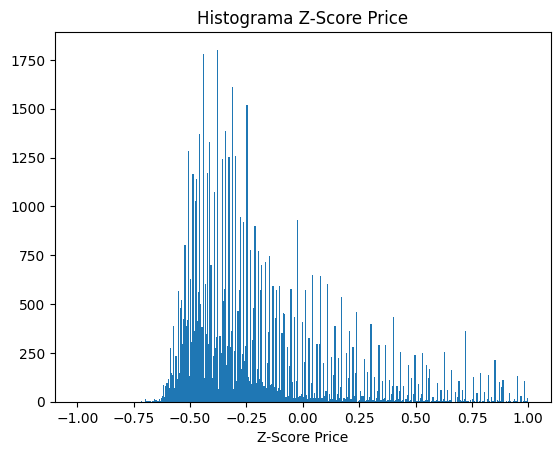

In [62]:
plt.hist(df.z_price, bins=400, range=(-1,1))
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.show()

##### Z-Score Modificado

In [63]:
mediana_price=np.nanmedian(df.property_price)
MAD=np.nanmedian(np.absolute(df.property_price-mediana_price))

df['zm_price']=(df.property_price - mediana_price)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [64]:
df[(df['zm_price']>3.5)].head()

id start_date   end_date created_on    latitud  \
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
387643  MGM2azMohIovCwT8jcExeQ== 2021-03-30 2021-04-27 2021-03-30 -34.612009   
403885  N/jyCx+vnAxpsyxmCuU4xg== 2021-08-13 2022-01-27 2021-08-13 -34.621092   
165091  LMqmEl4LAY5TKFXzvGlirg== 2021-01-21 2021-06-05 2021-01-21 -34.574988   
408105  DUAJw7dW3XPO8hlwhgdx/w== 2021-03-05 2021-03-10 2021-03-05 -34.573623   

         longitud         place_l2          place_l3          place_l4  \
19975  -58.359912  Capital Federal     Puerto Madero     Puerto Madero   
387643 -58.475824  Capital Federal  Villa del Parque  Villa del Parque   
403885 -58.376189  Capital Federal         San Telmo         San Telmo   
165091 -58.420192  Capital Federal           Palermo           Palermo   
408105 -58.421204  Capital Federal           Palermo           Palermo   

       property_type  ...  property_bedrooms  property_surface_total  \
19975   Departamento  ...                1.0                    70.0   
387643          Casa  ...                4.0                   320.0   
403885          Casa  ...                6.0                   511.0   
165091  Departamento  ...                2.0                   100.0   
408105  Departamento  ...                3.0                   140.0   

        property_surface_covered  property_price   z_rooms  zm_rooms  \
19975                       65.0        450000.0 -0.582906   -0.6745   
387643                     250.0        450000.0  1.509702    1.3490   
403885                     511.0        790000.0  3.602309    3.3725   
165091                      95.0        600000.0  0.114630    0.0000   
408105                     106.0        798000.0  0.812166    0.6745   

        z_bedrooms  zm_bedrooms   z_price  zm_price  
19975    -0.810085      -0.6745  0.724609  3.539711  
387643    1.841880       1.3490  0.724609  3.539711  
403885    3.609858       2.6980  1.825348  7.472723  
165091    0.073903       0.0000  1.210229  5.274863  
408105    0.957892       0.6745  1.851248  7.565264  

[5 rows x 21 columns]

In [65]:
df[(df['zm_price']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price]
Index: []

[0 rows x 21 columns]

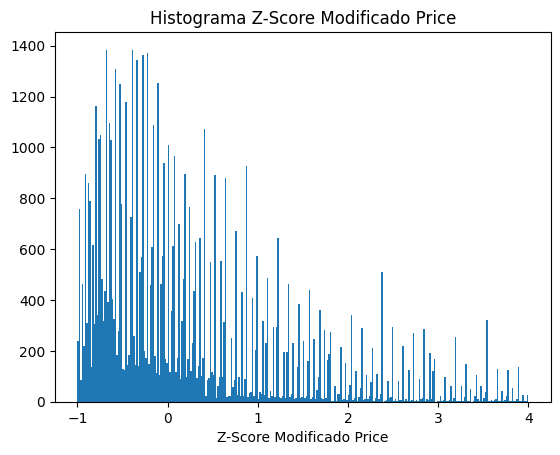

In [66]:
plt.hist(df.zm_price, bins=300, range=(-1,4))
plt.title('Histograma Z-Score Modificado Price')
plt.xlabel('Z-Score Modificado Price')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface covered

##### Box plot

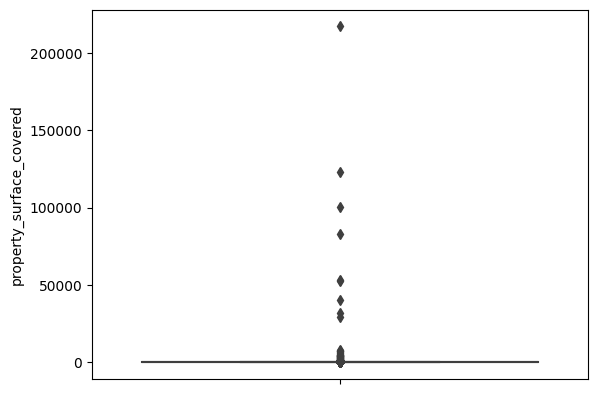

In [67]:
sns.boxplot(y=df.property_surface_covered)
plt.show()

In [68]:
Q1_property_surface_covered=df.describe().get("property_surface_covered").get("25%")
Q3_property_surface_covered=df.describe().get("property_surface_covered").get("75%")

print("El valor de Q1 es:", Q1_property_surface_covered)
print("El valor de Q3 es:", Q3_property_surface_covered)

IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 40.0
El valor de Q3 es: 89.0
El limite inferior del Q1 es: -33.5
El limite superior del Q3 es: 162.5


##### Z-Score

In [69]:
media_surface_covered=np.mean(df.property_surface_covered)
std_surface_covered=np.std(df.property_surface_covered)
df['z_surface_covered']=(df.property_surface_covered - media_surface_covered)/std_surface_covered

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [70]:
df[df['z_surface_covered']>3].head()

id start_date   end_date created_on    latitud  \
352883  aBZBrjan1XqHjgvjHK6K6Q== 2021-06-25 2021-07-08 2021-06-25 -34.550093   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05 2021-01-09 2021-01-05 -34.628282   
72316   BPTyNzwU2D4btCduu8ls3A== 2021-05-29 2021-06-08 2021-05-29 -34.578917   
372779  XzTb7kTEpmAKiyhEGSWz4A== 2021-08-24 2021-09-03 2021-08-24 -34.555278   
106598  +YPtNPAzbhoDCLgqF26Q8A== 2021-03-11 2021-04-20 2021-03-11 -34.587320   

         longitud         place_l2      place_l3      place_l4 property_type  \
352883 -58.483034  Capital Federal      Saavedra      Saavedra  Departamento   
459849 -58.437803  Capital Federal     Caballito     Caballito  Departamento   
72316  -58.429373  Capital Federal       Palermo       Palermo  Departamento   
372779 -58.459786  Capital Federal      Belgrano      Belgrano  Departamento   
106598 -58.401556  Capital Federal  Barrio Norte  Barrio Norte  Departamento   

        ...  property_surface_total  property_surface_covered  property_price  \
352883  ...                 29064.0                   29064.0         87400.0   
459849  ...                  7720.0                    5970.0        167894.0   
72316   ...                 61130.0                   53030.0        225000.0   
372779  ...                100068.0                  100051.0        420000.0   
106598  ...                 56740.0                   52540.0        175000.0   

         z_rooms  zm_rooms  z_bedrooms  zm_bedrooms   z_price  zm_price  \
352883 -1.280442   -1.3490   -0.810085      -0.6745 -0.449297 -0.654731   
459849  0.114630    0.0000    0.073903       0.0000 -0.188701  0.276398   
72316  -0.582906   -0.6745   -0.810085      -0.6745 -0.003822  0.936982   
372779  0.812166    0.6745    0.957892       0.6745  0.627485  3.192680   
106598 -0.582906   -0.6745   -0.810085      -0.6745 -0.165695  0.358598   

        z_surface_covered  
352883          26.734330  
459849           5.425392  
72316           48.847867  
372779          92.234356  
106598          48.395742  

[5 rows x 22 columns]

In [71]:
df[df['z_surface_covered']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered]
Index: []

[0 rows x 22 columns]

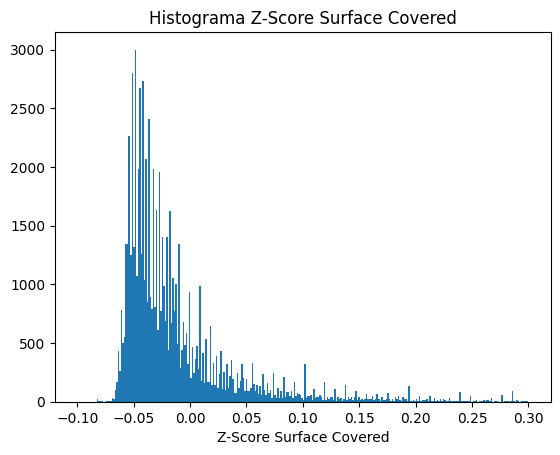

In [72]:
plt.hist(df.z_surface_covered, bins=300, range=(-0.1,0.3))
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Z-Score Modificado

In [73]:
mediana_surface_covered=np.nanmedian(df.property_surface_covered)
MAD=np.nanmedian(np.absolute(df.property_surface_covered-mediana_surface_covered))

df['zm_surface_covered']=(df.property_surface_covered - mediana_surface_covered)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [74]:
df[(df['zm_surface_covered']>3.5)].head()

id start_date   end_date created_on    latitud  \
387643  MGM2azMohIovCwT8jcExeQ== 2021-03-30 2021-04-27 2021-03-30 -34.612009   
403885  N/jyCx+vnAxpsyxmCuU4xg== 2021-08-13 2022-01-27 2021-08-13 -34.621092   
266776  T1g0pGYdDflgb2YLc6rCKQ== 2021-09-02 2021-09-02 2021-09-02 -34.616105   
155779  7pcoT994dx5/Rf9Z3VtSow== 2021-04-05 2021-04-15 2021-04-05 -34.566853   
424845  5PfALVXCKBuTj0wT2l0DxA== 2021-12-16 2022-01-27 2021-12-16 -34.643476   

         longitud         place_l2          place_l3          place_l4  \
387643 -58.475824  Capital Federal  Villa del Parque  Villa del Parque   
403885 -58.376189  Capital Federal         San Telmo         San Telmo   
266776 -58.430122  Capital Federal         Caballito         Caballito   
155779 -58.446764  Capital Federal          Belgrano          Belgrano   
424845 -58.463102  Capital Federal            Flores            Flores   

       property_type  ...  property_surface_covered  property_price   z_rooms  \
387643          Casa  ...                     250.0        450000.0  1.509702   
403885          Casa  ...                     511.0        790000.0  3.602309   
266776            PH  ...                     270.0        499000.0  1.509702   
155779  Departamento  ...                     380.0       1300000.0  1.509702   
424845          Casa  ...                     238.0        189000.0  1.509702   

        zm_rooms  z_bedrooms  zm_bedrooms   z_price   zm_price  \
387643    1.3490    1.841880        1.349  0.724609   3.539711   
403885    3.3725    3.609858        2.698  1.825348   7.472723   
266776    1.3490    1.841880        1.349  0.883245   4.106527   
155779    1.3490    1.841880        1.349  3.476457  13.372241   
424845    1.3490    1.841880        1.349 -0.120371   0.520546   

        z_surface_covered  zm_surface_covered  
387643           0.147522            6.166857  
403885           0.388348           14.549929  
266776           0.165976            6.809238  
155779           0.267473           10.342333  
424845           0.136449            5.781429  

[5 rows x 23 columns]

In [75]:
df[(df['zm_surface_covered']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered]
Index: []

[0 rows x 23 columns]

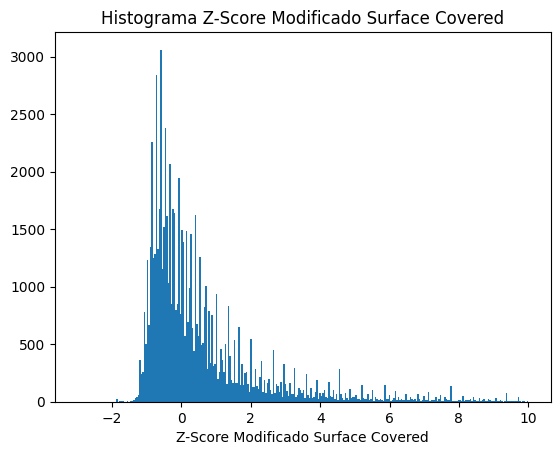

In [76]:
plt.hist(df.zm_surface_covered, bins=300, range=(-3,10))
plt.title('Histograma Z-Score Modificado Surface Covered')
plt.xlabel('Z-Score Modificado Surface Covered')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface total

##### Box plot

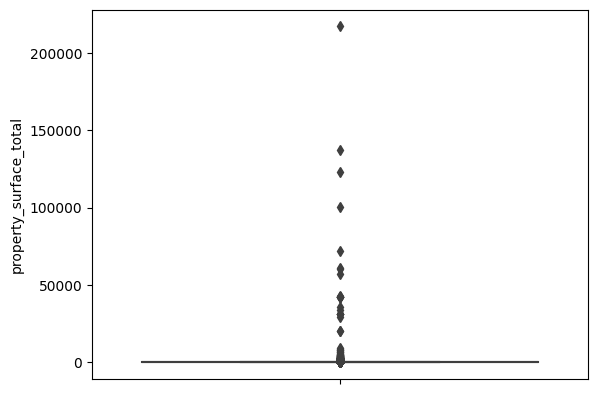

In [77]:
sns.boxplot(y=df.property_surface_total)
plt.show()

In [78]:
Q1_property_surface_total=df.describe().get("property_surface_total").get("25%")
Q3_property_surface_total=df.describe().get("property_surface_total").get("75%")

print("El valor de Q1 es:", Q1_property_surface_total)
print("El valor de Q3 es:", Q3_property_surface_total)

IQR_property_surface_total=Q3_property_surface_total-Q1_property_surface_total

out_inf=Q1_property_surface_total-1.5*IQR_property_surface_total
out_sup=Q3_property_surface_total+1.5*IQR_property_surface_total
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 45.0
El valor de Q3 es: 105.0
El limite inferior del Q1 es: -45.0
El limite superior del Q3 es: 195.0


##### Z-Score

In [79]:
media_surface_total=np.mean(df.property_surface_total)
std_surface_total=np.std(df.property_surface_total)
df['z_surface_total']=(df.property_surface_total - media_surface_total)/std_surface_total

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [80]:
df[df['z_surface_total']>3].head()

id start_date   end_date created_on    latitud  \
370917  OC6HYSBo/pqio5ZTLgoPvg== 2021-04-24 2021-06-05 2021-04-24 -34.571747   
352883  aBZBrjan1XqHjgvjHK6K6Q== 2021-06-25 2021-07-08 2021-06-25 -34.550093   
189057  gckpFFbQkpnfPsuwEPk0Hg== 2021-06-04 2021-06-05 2021-06-04 -31.459563   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05 2021-01-09 2021-01-05 -34.628282   
72316   BPTyNzwU2D4btCduu8ls3A== 2021-05-29 2021-06-08 2021-05-29 -34.578917   

         longitud         place_l2         place_l3         place_l4  \
370917 -58.422612  Capital Federal          Palermo          Palermo   
352883 -58.483034  Capital Federal         Saavedra         Saavedra   
189057 -64.407188  Capital Federal  Capital Federal  Capital Federal   
459849 -58.437803  Capital Federal        Caballito        Caballito   
72316  -58.429373  Capital Federal          Palermo          Palermo   

       property_type  ...  property_price   z_rooms  zm_rooms  z_bedrooms  \
370917  Departamento  ...       1910920.0  0.812166    0.6745    0.957892   
352883  Departamento  ...         87400.0 -1.280442   -1.3490   -0.810085   
189057          Casa  ...        850000.0  0.812166    0.6745    0.957892   
459849  Departamento  ...        167894.0  0.114630    0.0000    0.073903   
72316   Departamento  ...        225000.0 -0.582906   -0.6745   -0.810085   

        zm_bedrooms   z_price   zm_price  z_surface_covered  \
370917       0.6745  5.454291  20.439170           0.121686   
352883      -0.6745 -0.449297  -0.654731          26.734330   
189057       0.6745  2.019596   8.166784           0.332063   
459849       0.0000 -0.188701   0.276398           5.425392   
72316       -0.6745 -0.003822   0.936982          48.847867   

        zm_surface_covered  z_surface_total  
370917            5.267524        32.119577  
352883          931.645095        22.141889  
189057           12.590667         3.125696  
459849          189.887810         5.817821  
72316          1701.410190        46.666230  

[5 rows x 24 columns]

In [81]:
df[df['z_surface_total']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered, z_surface_total]
Index: []

[0 rows x 24 columns]

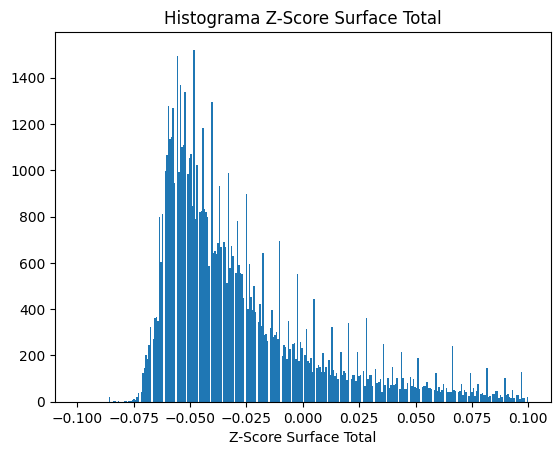

In [82]:
plt.hist(df.z_surface_total, bins=300, range=(-0.1,0.1))
plt.title('Histograma Z-Score Surface Total')
plt.xlabel('Z-Score Surface Total')
plt.show()

##### Z-Score Modificado

In [83]:
mediana_surface_total=np.nanmedian(df.property_surface_total)
MAD=np.nanmedian(np.absolute(df.property_surface_total-mediana_surface_total))

df['zm_surface_total']=(df.property_surface_total - mediana_surface_total)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [84]:
df[(df['zm_surface_total']>3.5)].head()

id start_date   end_date created_on    latitud  \
387643  MGM2azMohIovCwT8jcExeQ== 2021-03-30 2021-04-27 2021-03-30 -34.612009   
403885  N/jyCx+vnAxpsyxmCuU4xg== 2021-08-13 2022-01-27 2021-08-13 -34.621092   
266776  T1g0pGYdDflgb2YLc6rCKQ== 2021-09-02 2021-09-02 2021-09-02 -34.616105   
155779  7pcoT994dx5/Rf9Z3VtSow== 2021-04-05 2021-04-15 2021-04-05 -34.566853   
424845  5PfALVXCKBuTj0wT2l0DxA== 2021-12-16 2022-01-27 2021-12-16 -34.643476   

         longitud         place_l2          place_l3          place_l4  \
387643 -58.475824  Capital Federal  Villa del Parque  Villa del Parque   
403885 -58.376189  Capital Federal         San Telmo         San Telmo   
266776 -58.430122  Capital Federal         Caballito         Caballito   
155779 -58.446764  Capital Federal          Belgrano          Belgrano   
424845 -58.463102  Capital Federal            Flores            Flores   

       property_type  ...   z_rooms  zm_rooms  z_bedrooms  zm_bedrooms  \
387643          Casa  ...  1.509702    1.3490    1.841880        1.349   
403885          Casa  ...  3.602309    3.3725    3.609858        2.698   
266776            PH  ...  1.509702    1.3490    1.841880        1.349   
155779  Departamento  ...  1.509702    1.3490    1.841880        1.349   
424845          Casa  ...  1.509702    1.3490    1.841880        1.349   

         z_price   zm_price  z_surface_covered  zm_surface_covered  \
387643  0.724609   3.539711           0.147522            6.166857   
403885  1.825348   7.472723           0.388348           14.549929   
266776  0.883245   4.106527           0.165976            6.809238   
155779  3.476457  13.372241           0.267473           10.342333   
424845 -0.120371   0.520546           0.136449            5.781429   

        z_surface_total  zm_surface_total  
387643         0.158240           6.87990  
403885         0.304319          12.03308  
266776         0.165888           7.14970  
155779         0.204129           8.49870  
424845         0.095526           4.66754  

[5 rows x 25 columns]

In [85]:
df[(df['zm_surface_total']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered, z_surface_total, zm_surface_total]
Index: []

[0 rows x 25 columns]

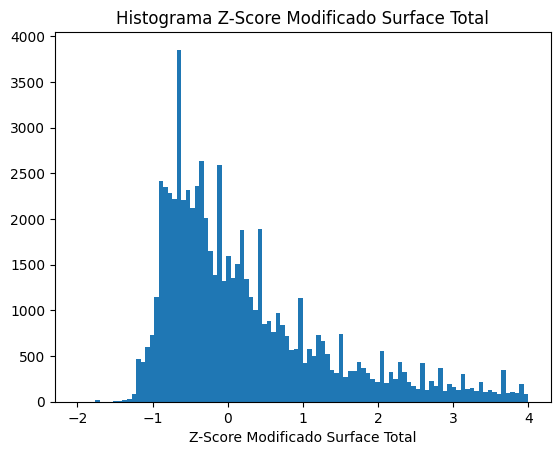

In [86]:
plt.hist(df.zm_surface_total, bins=100, range=(-2,4))
plt.title('Histograma Z-Score Modificado Surface Total')
plt.xlabel('Z-Score Modificado Surface Total')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

### Outliers multivariados

---

Para el análisis de outliers de tipo multivariados estaremos utilizando el método de Mahalanobis el cual nos brinda información respecto de la distancia de las observaciones agrupando las similares en clusters, evidenciando así los puntos aislados que pasaremos a considerar como valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Preparación del dataset para el estudio de Mahalanobis

Para la utilización del método, analizamos la presencia de valores `nan` en nuestro dataset y analizamos la posibilidad de descartar los mismos en caso de existir nulos.

In [87]:
mahal = df.copy()
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    4069
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

Procedemos a eliminar los registros en cuestión dado que representan una pequeña porción del dataset y no se verán afectados los resultados.

In [88]:
mahal.dropna(subset=['property_rooms', 'property_bedrooms'], inplace = True)
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    4069
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

#### Property surface total vs Price



##### Scatter


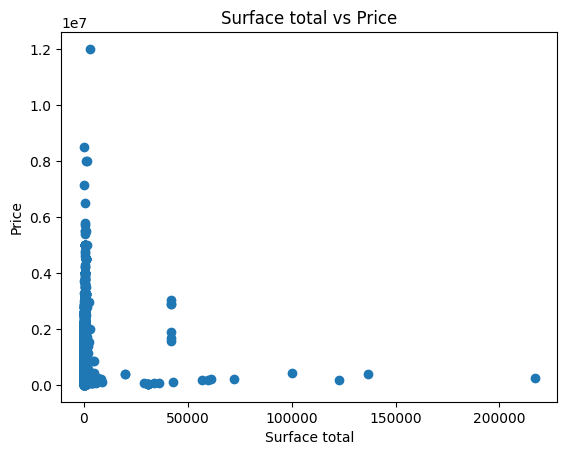

In [89]:
plt.scatter(mahal.property_surface_total,mahal.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [90]:
X = mahal[['property_surface_total','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_sfto_prc'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   

         longitud         place_l2       place_l3       place_l4  \
92828  -58.448886  Capital Federal      Caballito      Caballito   
19975  -58.359912  Capital Federal  Puerto Madero  Puerto Madero   
266756 -58.398106  Capital Federal      Balvanera      Balvanera   
454638 -58.390007  Capital Federal    San Nicolás    San Nicolás   
409114 -58.381426  Capital Federal         Retiro         Retiro   

       property_type  ...  zm_rooms  z_bedrooms  zm_bedrooms   z_price  \
92828   Departamento  ...    0.6745    0.957892       0.6745  0.200139   
19975   Departamento  ...   -0.6745   -0.810085      -0.6745  0.724609   
266756  Departamento  ...   -1.3490   -0.810085      -0.6745 -0.482180   
454638  Departamento  ...   -1.3490   -0.810085      -0.6745 -0.521817   
409114  Departamento  ...   -1.3490   -0.810085      -0.6745 -0.476492   

        zm_price  z_surface_covered  zm_surface_covered  z_surface_total  \
92828   1.665746           0.006348            1.252643        -0.000075   
19975   3.539711          -0.023179            0.224833        -0.032962   
266756 -0.772224          -0.055473           -0.899333        -0.061260   
454638 -0.913847          -0.055473           -0.899333        -0.063554   
409114 -0.751899          -0.046246           -0.578143        -0.055906   

        zm_surface_total  mahal_sfto_prc  
92828            1.29504        0.062118  
19975            0.13490        1.070311  
266756          -0.86336        0.336919  
454638          -0.94430        0.387282  
409114          -0.67450        0.305213  

[5 rows x 26 columns]

In [91]:
np.sort(mahal.mahal_sfto_prc)

array([9.16266214e-06, 9.16266214e-06, 9.16266214e-06, ...,
       1.08127288e+06, 1.34066737e+06, 3.36683024e+06])

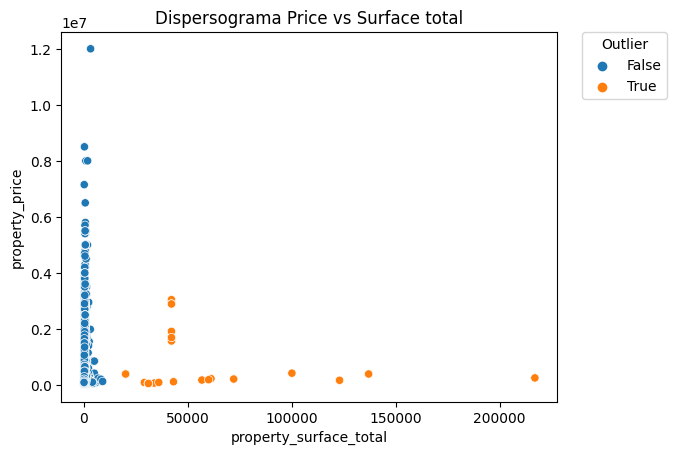

In [92]:
umbral=10000
mahal[mahal['mahal_sfto_prc']>umbral]

es_outlier = (mahal['mahal_sfto_prc'] > umbral)
sns.scatterplot(x=mahal.property_surface_total,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Price vs Surface total')
plt.show()

##### Caracteristicas

Podemos visualizar que los valores que se encuentran particularmente alejados de la masa de observaciones caben dentro de la clasificación de outliers globales.

#### Property rooms vs Property bedrooms

##### Scatter

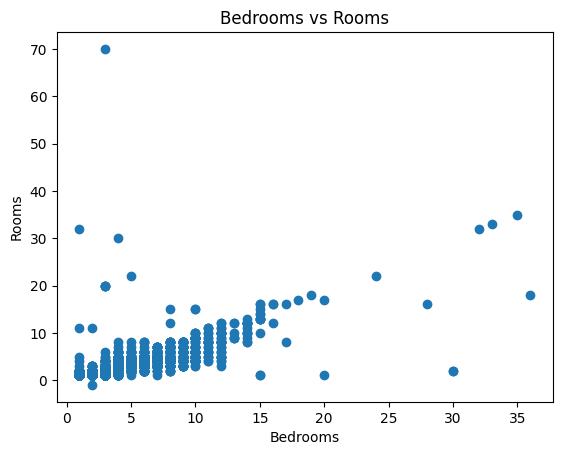

In [93]:
plt.scatter(mahal.property_rooms,mahal.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Mahalanobis

In [94]:
X = mahal[['property_rooms','property_bedrooms']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_bdro'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   

         longitud         place_l2       place_l3       place_l4  \
92828  -58.448886  Capital Federal      Caballito      Caballito   
19975  -58.359912  Capital Federal  Puerto Madero  Puerto Madero   
266756 -58.398106  Capital Federal      Balvanera      Balvanera   
454638 -58.390007  Capital Federal    San Nicolás    San Nicolás   
409114 -58.381426  Capital Federal         Retiro         Retiro   

       property_type  ...  z_bedrooms  zm_bedrooms   z_price  zm_price  \
92828   Departamento  ...    0.957892       0.6745  0.200139  1.665746   
19975   Departamento  ...   -0.810085      -0.6745  0.724609  3.539711   
266756  Departamento  ...   -0.810085      -0.6745 -0.482180 -0.772224   
454638  Departamento  ...   -0.810085      -0.6745 -0.521817 -0.913847   
409114  Departamento  ...   -0.810085      -0.6745 -0.476492 -0.751899   

        z_surface_covered  zm_surface_covered  z_surface_total  \
92828            0.006348            1.252643        -0.000075   
19975           -0.023179            0.224833        -0.032962   
266756          -0.055473           -0.899333        -0.061260   
454638          -0.055473           -0.899333        -0.063554   
409114          -0.046246           -0.578143        -0.055906   

        zm_surface_total  mahal_sfto_prc  mahal_ro_bdro  
92828            1.29504        0.062118       0.805039  
19975            0.13490        1.070311       0.472739  
266756          -0.86336        0.336919       1.847844  
454638          -0.94430        0.387282       1.847844  
409114          -0.67450        0.305213       1.847844  

[5 rows x 27 columns]

In [95]:
np.sort(mahal.mahal_ro_bdro)

array([2.14351696e-02, 2.14351696e-02, 2.14351696e-02, ...,
       9.41942470e+02, 1.24985078e+03, 5.85489881e+03])

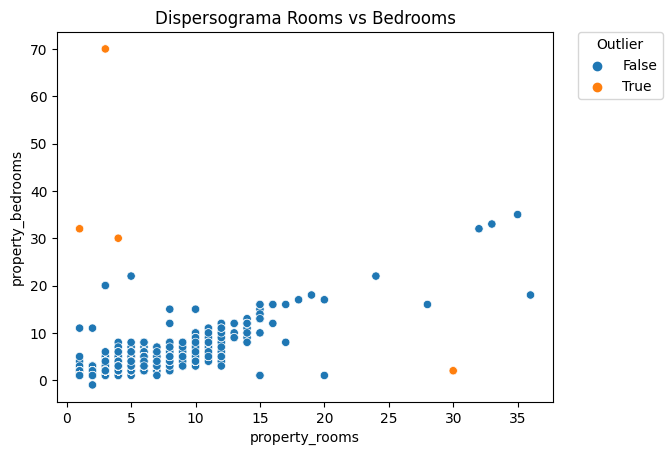

In [96]:
umbral=700
mahal[mahal['mahal_ro_bdro']>umbral]

es_outlier = (mahal['mahal_ro_bdro'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_bedrooms, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Bedrooms')
plt.show()

##### Caracteristicas

Notamos que estamos en presencia de outliers en su mayoría globales, con la particularidad de que tenemos algunos casos de valores atípicos colectivos en las cercanías del rango equivalente a 30 respecto del eje `property_bedrooms`.

Adicionalmente, cabe destacar que hay dos valores particularmente alejados. Siguiendo esta línea, llegamos a la conclusión de que estamos en presencia de outliers globales.

#### Property rooms vs Property surface total

##### Scatter


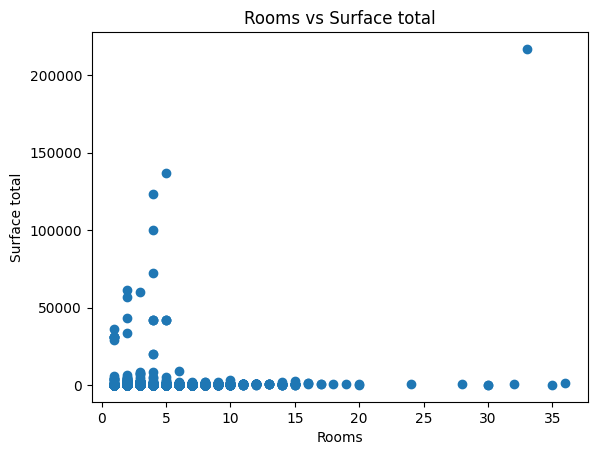

In [97]:
plt.scatter(mahal.property_rooms,mahal.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [98]:
X = mahal[['property_rooms','property_surface_total']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfto'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   

         longitud         place_l2       place_l3       place_l4  \
92828  -58.448886  Capital Federal      Caballito      Caballito   
19975  -58.359912  Capital Federal  Puerto Madero  Puerto Madero   
266756 -58.398106  Capital Federal      Balvanera      Balvanera   
454638 -58.390007  Capital Federal    San Nicolás    San Nicolás   
409114 -58.381426  Capital Federal         Retiro         Retiro   

       property_type  ...  zm_bedrooms   z_price  zm_price  z_surface_covered  \
92828   Departamento  ...       0.6745  0.200139  1.665746           0.006348   
19975   Departamento  ...      -0.6745  0.724609  3.539711          -0.023179   
266756  Departamento  ...      -0.6745 -0.482180 -0.772224          -0.055473   
454638  Departamento  ...      -0.6745 -0.521817 -0.913847          -0.055473   
409114  Departamento  ...      -0.6745 -0.476492 -0.751899          -0.046246   

        zm_surface_covered  z_surface_total  zm_surface_total  mahal_sfto_prc  \
92828             1.252643        -0.000075           1.29504        0.062118   
19975             0.224833        -0.032962           0.13490        1.070311   
266756           -0.899333        -0.061260          -0.86336        0.336919   
454638           -0.899333        -0.063554          -0.94430        0.387282   
409114           -0.578143        -0.055906          -0.67450        0.305213   

        mahal_ro_bdro  mahal_ro_sfto  
92828        0.805039       0.671893  
19975        0.472739       0.351811  
266756       1.847844       1.683544  
454638       1.847844       1.683338  
409114       1.847844       1.684519  

[5 rows x 28 columns]

In [99]:
np.sort(mahal.mahal_ro_sfto)

array([1.24053307e-02, 1.24053307e-02, 1.24053307e-02, ...,
       1.06712219e+05, 1.32344795e+05, 3.29482360e+05])

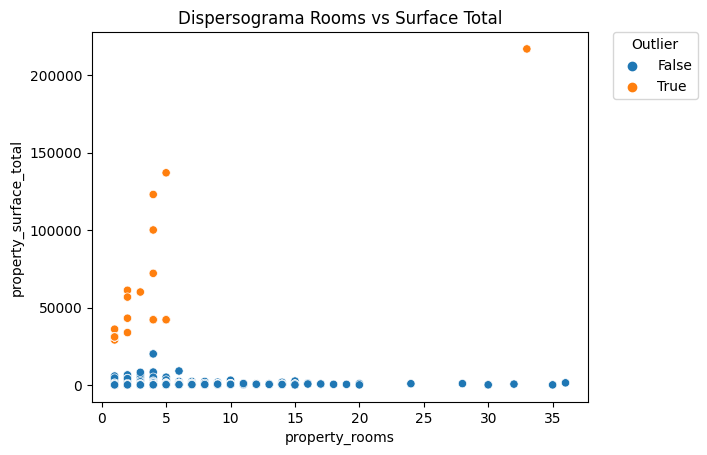

In [100]:
umbral=5000
mahal[mahal['mahal_ro_sfto']>umbral]

es_outlier = (mahal['mahal_ro_sfto'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_total, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Total')
plt.show()

##### Caracteristicas

En esta nueva comparación, contamos -una vez más- con la presencia de registros aislados en la parte superior izquierda que podríamos clasificarlos como outliers globales.

#### Property rooms vs Property surface covered

##### Scatter

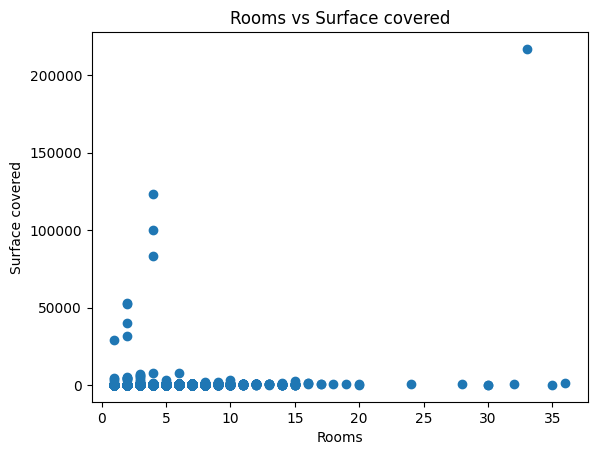

In [101]:
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Mahalanobis

In [102]:
X = mahal[['property_rooms','property_surface_covered']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfcv'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   

         longitud         place_l2       place_l3       place_l4  \
92828  -58.448886  Capital Federal      Caballito      Caballito   
19975  -58.359912  Capital Federal  Puerto Madero  Puerto Madero   
266756 -58.398106  Capital Federal      Balvanera      Balvanera   
454638 -58.390007  Capital Federal    San Nicolás    San Nicolás   
409114 -58.381426  Capital Federal         Retiro         Retiro   

       property_type  ...   z_price  zm_price  z_surface_covered  \
92828   Departamento  ...  0.200139  1.665746           0.006348   
19975   Departamento  ...  0.724609  3.539711          -0.023179   
266756  Departamento  ... -0.482180 -0.772224          -0.055473   
454638  Departamento  ... -0.521817 -0.913847          -0.055473   
409114  Departamento  ... -0.476492 -0.751899          -0.046246   

        zm_surface_covered  z_surface_total  zm_surface_total  mahal_sfto_prc  \
92828             1.252643        -0.000075           1.29504        0.062118   
19975             0.224833        -0.032962           0.13490        1.070311   
266756           -0.899333        -0.061260          -0.86336        0.336919   
454638           -0.899333        -0.063554          -0.94430        0.387282   
409114           -0.578143        -0.055906          -0.67450        0.305213   

        mahal_ro_bdro  mahal_ro_sfto  mahal_ro_sfcv  
92828        0.805039       0.671893       0.627125  
19975        0.472739       0.351811       0.338078  
266756       1.847844       1.683544       1.603559  
454638       1.847844       1.683338       1.603559  
409114       1.847844       1.684519       1.605540  

[5 rows x 29 columns]

In [103]:
np.sort(mahal.mahal_ro_sfcv)

array([9.79093872e-03, 9.79093872e-03, 9.79105744e-03, ...,
       1.38562702e+03, 2.09871161e+03, 6.23295552e+03])

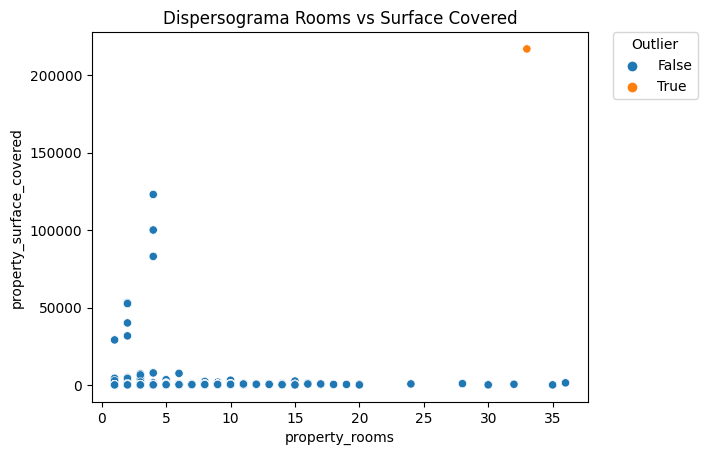

In [104]:
umbral=3000
mahal[mahal['mahal_ro_sfcv']>umbral]

es_outlier = (mahal['mahal_ro_sfcv'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_covered, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Covered')
plt.show()

##### Caracteristicas

Luego de la comparación de surface covered vs property rooms, notamos que nuevamente estamos en presencia de outliers, en particular esta vez todos de carácter global.


#### Property rooms vs Property price

##### Scatter

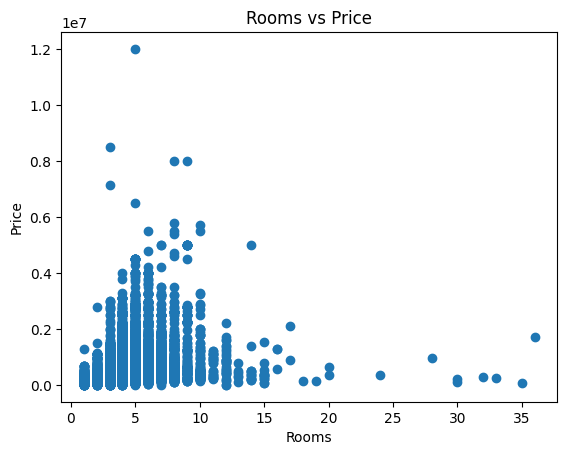

In [105]:
plt.scatter(mahal.property_rooms,mahal.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [106]:
X = mahal[['property_rooms','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_pr'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
19975   p7gmyqzdOy/+odHwH5oPyg== 2021-01-27 2021-06-05 2021-01-27 -34.618084   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   

         longitud         place_l2       place_l3       place_l4  \
92828  -58.448886  Capital Federal      Caballito      Caballito   
19975  -58.359912  Capital Federal  Puerto Madero  Puerto Madero   
266756 -58.398106  Capital Federal      Balvanera      Balvanera   
454638 -58.390007  Capital Federal    San Nicolás    San Nicolás   
409114 -58.381426  Capital Federal         Retiro         Retiro   

       property_type  ...  zm_price  z_surface_covered  zm_surface_covered  \
92828   Departamento  ...  1.665746           0.006348            1.252643   
19975   Departamento  ...  3.539711          -0.023179            0.224833   
266756  Departamento  ... -0.772224          -0.055473           -0.899333   
454638  Departamento  ... -0.913847          -0.055473           -0.899333   
409114  Departamento  ... -0.751899          -0.046246           -0.578143   

        z_surface_total  zm_surface_total  mahal_sfto_prc  mahal_ro_bdro  \
92828         -0.000075           1.29504        0.062118       0.805039   
19975         -0.032962           0.13490        1.070311       0.472739   
266756        -0.061260          -0.86336        0.336919       1.847844   
454638        -0.063554          -0.94430        0.387282       1.847844   
409114        -0.055906          -0.67450        0.305213       1.847844   

        mahal_ro_sfto  mahal_ro_sfcv  mahal_ro_pr  
92828        0.671893       0.627125     0.732204  
19975        0.351811       0.338078     1.675559  
266756       1.683544       1.603559     1.666347  
454638       1.683338       1.603559     1.652432  
409114       1.684519       1.605540     1.668680  

[5 rows x 30 columns]

In [107]:
np.sort(mahal.mahal_ro_pr)

array([1.50187227e-02, 1.50187227e-02, 1.50187227e-02, ...,
       7.25749002e+02, 9.31793225e+02, 1.82329557e+03])

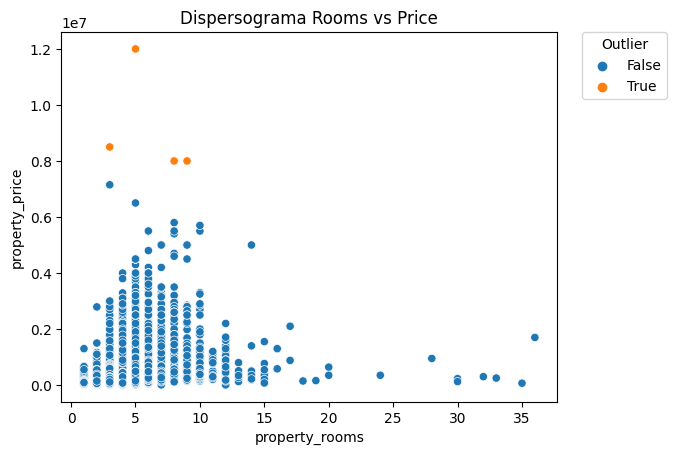

In [108]:
umbral=700
mahal[mahal['mahal_ro_pr']>umbral]

es_outlier = (mahal['mahal_ro_pr'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Price')
plt.show()

##### Caracteristicas

Nuevamente visualizamos outliers globales.

### Tratamiento

Para cada una de las variables, estudiamos si es posible eliminar los valores atípicos encontrados con los métodos previamente descriptos analizando la proporción que estos representan sobre el total de los valores, teniendo en cuenta la decisión de admitir una tolerancia del 10% de otuliers.

#### Property rooms

In [109]:
rooms_outliers_porcentaje = df[(df['zm_rooms']>3.5)].shape[0]/df['zm_rooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_rooms representan un {round(rooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_rooms representan un 0.426% del total del dataset.


Eliminamos los outliers del dataset:

In [110]:
df.drop(df[df['zm_rooms']>3.5].index, inplace=True)

#### Property bedrooms

In [111]:
bedrooms_outliers_porcentaje = df[(df['zm_bedrooms']>3.5)].shape[0]/df['zm_bedrooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_bedrooms representan un {round(bedrooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_bedrooms representan un 0.032% del total del dataset.


In [112]:
df.drop(df[df['zm_bedrooms']>3.5].index, inplace=True)

#### Property price

In [113]:
price_outliers_porcentaje = df[(df['zm_price']>3.5)].shape[0]/df['zm_price'].shape[0]*100

print(f"Los valores atípicos encontrados para property_price representan un {round(price_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_price representan un 8.875% del total del dataset.


In [114]:
df.drop(df[df['zm_price']>3.5].index, inplace=True)

#### Property surface covered

In [115]:
surface_covered_outliers_porcentaje = df[(df['zm_surface_covered']>3.5)].shape[0]/df['zm_surface_covered'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_covered representan un {round(surface_covered_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_covered representan un 2.508% del total del dataset.


In [116]:
df.drop(df[df['zm_surface_covered']>3.5].index, inplace=True)

#### Property surface total

In [117]:
surface_total_outliers_porcentaje = df[(df['zm_surface_total']>3.5)].shape[0]/df['zm_surface_total'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_total representan un {round(surface_total_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_total representan un 1.516% del total del dataset.


In [118]:
df.drop(df[df['zm_surface_total']>3.5].index, inplace=True)

## **1d. Reducción de la dimensionalidad**

Para realizar la reducción de la dimensionalidad del dataset, estaremos utilizando el algoritmo PCA con el objetivo de reducir la dimensión del problema descartando la información redundante existente.

Generamos un nuevo dataset de reducción de dimensionalidad:

In [119]:
df_reduc = df.copy()

Antes de ejecutar el algoritmo, verificamos que no existan nulos para las variables de importancia que no brinden información de relevancia. En caso de existir, los eliminamos.

In [120]:
df_reduc.drop(df_reduc[df_reduc['property_rooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_bedrooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_price'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_covered'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_total'].isna()].index, inplace=True)

Normalizamos el data set

In [121]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_covered', 'property_surface_total']

x = df_reduc.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

In [122]:
pca = PCA(n_components=4)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4'])

In [123]:
df_reduc['target'] = 0
target = pd.DataFrame((np.column_stack(df_reduc['target'])).tolist()).T
df_pca = pd.concat([pca_df_aux, target], axis = 1)
df_pca.columns= ['cp_1', 'cp_2','cp_3','cp_4','target']
df_pca.head()

cp_1      cp_2      cp_3      cp_4  target
0  2.824265  0.156156  0.162303  0.057658       0
1 -2.188546 -0.080832  0.407981  0.031628       0
2 -2.232467 -0.030093  0.411418 -0.026497       0
3 -1.904769 -0.350321  0.433037 -0.099681       0
4  5.291453 -0.578361 -1.190110  0.686330       0

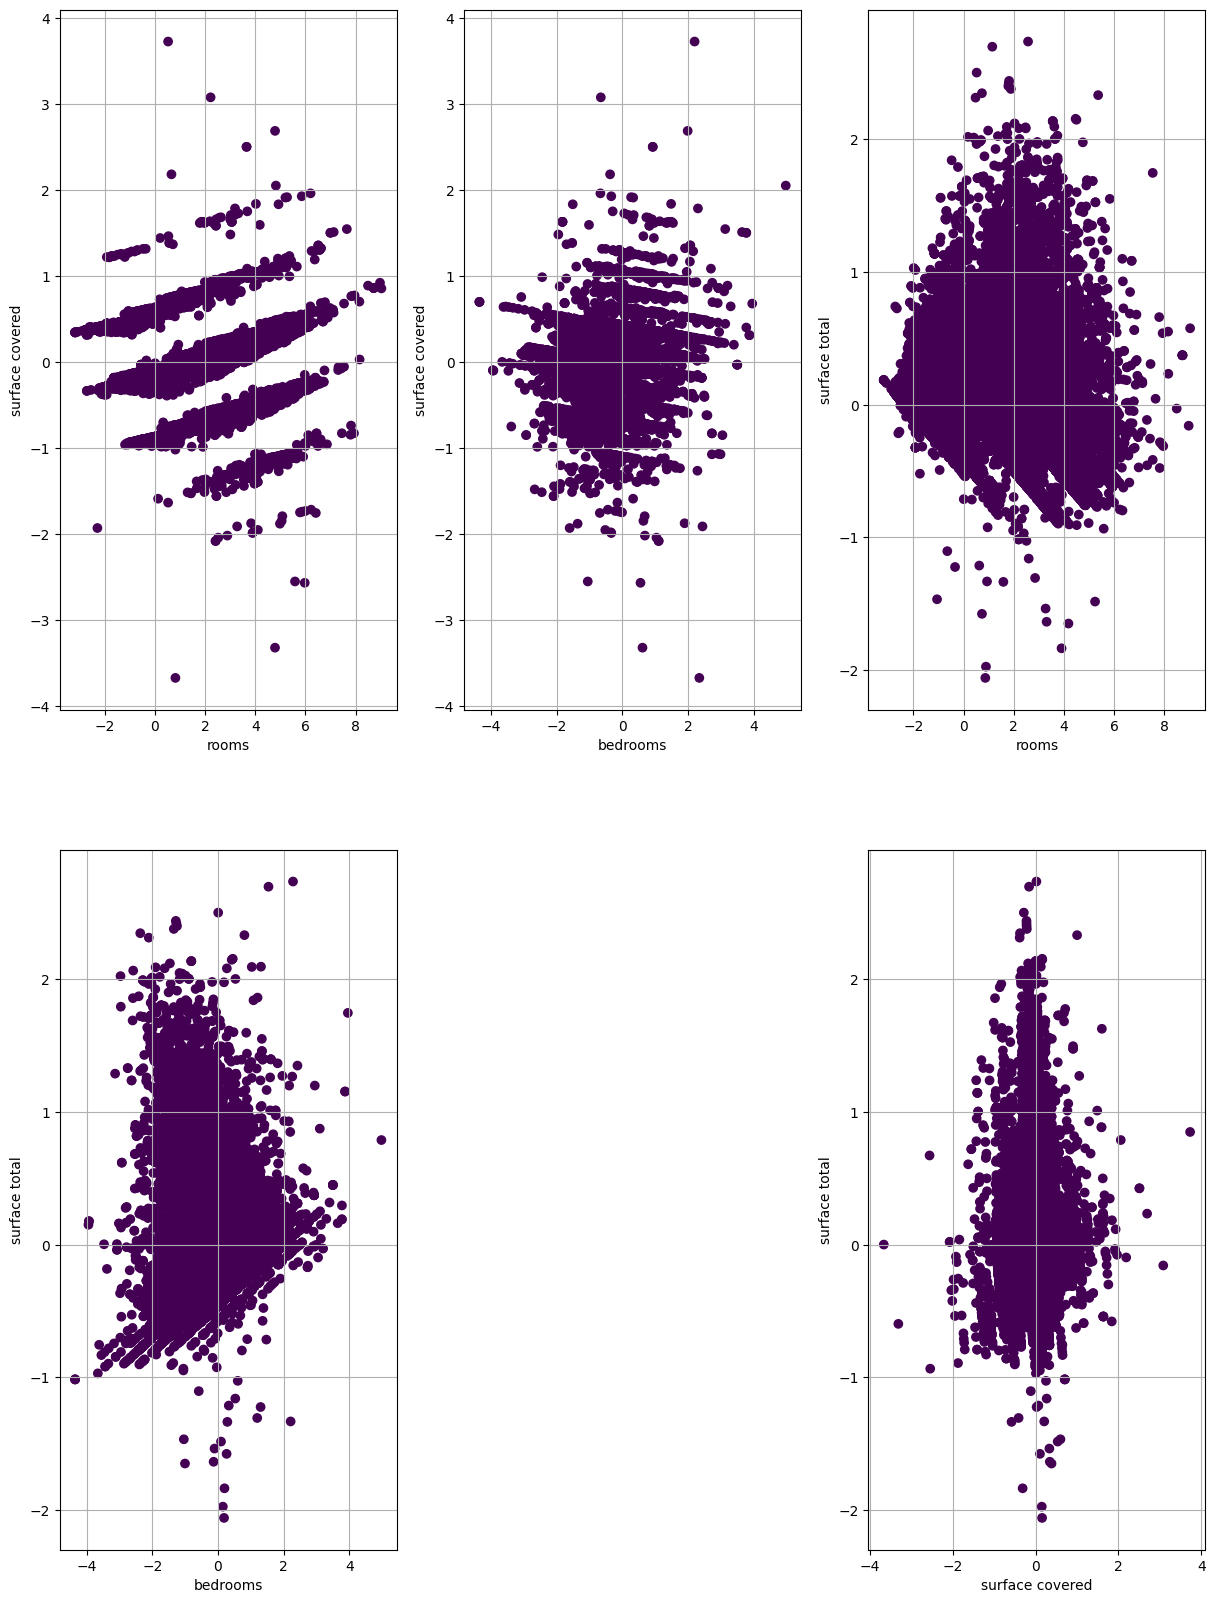

In [124]:
targets = ['Casa', 'PH', 'Departamento']

fig = plt.figure(figsize = (20,20))

c = df_pca['target']

# plot 1

ax = fig.add_subplot(2, 4, 1) 

x = df_pca['cp_1']
y = df_pca['cp_3']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface covered', fontsize = 10)
ax.grid()

# plot 2

ax = fig.add_subplot(2, 4, 2) 

x = df_pca['cp_2']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface covered', fontsize = 10)
ax.grid()

# plot 3

ax = fig.add_subplot(2, 4, 3) 

x = df_pca['cp_1']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface total', fontsize = 10)
ax.grid()

# plot 5

ax = fig.add_subplot(2, 4, 5) 

x = df_pca['cp_2']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface total', fontsize = 10)
ax.grid()

# plot 7

ax = fig.add_subplot(2, 4, 7) 

x = df_pca['cp_3']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('surface covered', fontsize = 10)
ax.set_ylabel('surface total', fontsize = 10)
ax.grid()

plt.show()

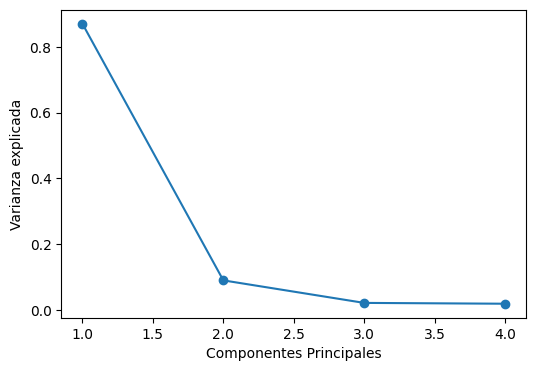

In [125]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada, '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

Exporto el data set

In [126]:
df_reduc.to_csv('./ds_reduc_dim.csv')

#  **2. Agrupamiento**

Primero removemos entradas del dataframe que contienen coordenadas fuera de CABA



In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

CABA_lat = -34.611817
CABA_long = -58.446881

df = df.loc[((CABA_lat - 0.5) < df["latitud"]) & (df["latitud"] < (CABA_lat + 0.5))]
df = df.loc[((CABA_long - 0.5) < df["longitud"]) & (df["longitud"] < (CABA_long + 0.5))]

El primer análisis de clustering lo realizamos entre las variables longitud y latitud, viendo la tendencia al agrupamiento que existe en la posición geográfica:



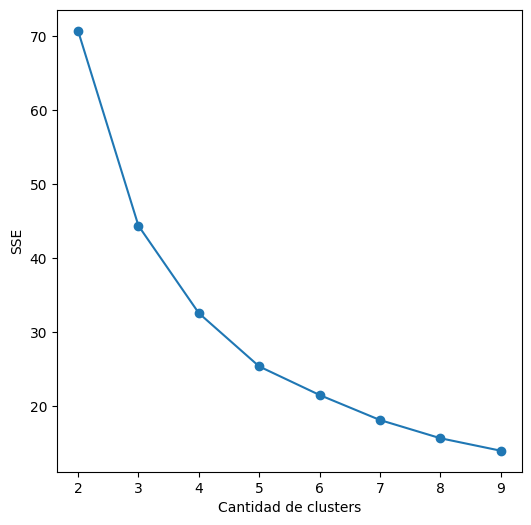

In [128]:
X = np.column_stack((df.longitud.tolist(), df.latitud.tolist()))

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Utilizando 5 clusters



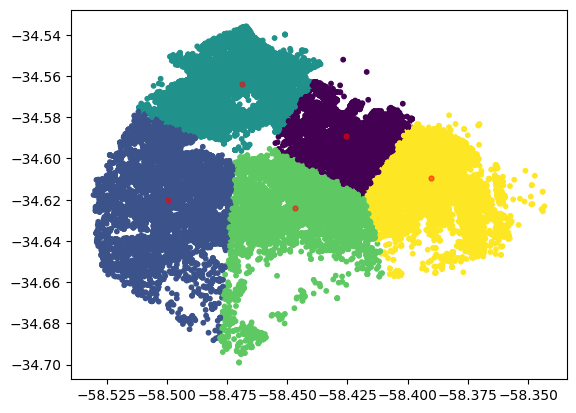

Silhouette Score para 5 clusters = 0.4092450554325348


In [129]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()
print ("Silhouette Score para 5 clusters = " + str(silhouette_score(X, y_kmeans)))

Utilizando 3 clusters



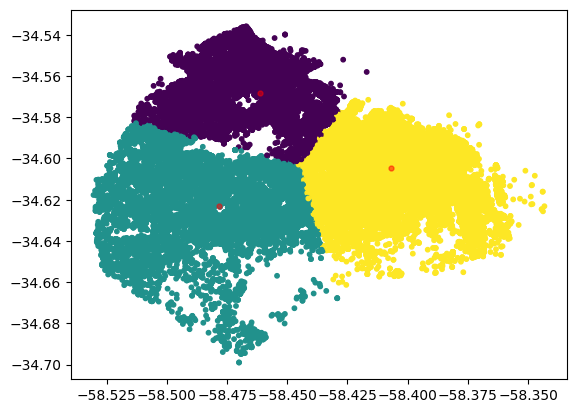

Silhouette Score para 3 clusters = 0.45831142281966275


In [130]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()

print ("Silhouette Score para 3 clusters = " + str(silhouette_score(X, y_kmeans)))

Viendo la curva de cantidad de clusters contra la distancia media al centroide (SSE) podemos ver que no existen clusters definidos, no se ve un claro codo en el cual elegir un numero de clusters ideal. No existen agrupamientos definidos.

Un segundo análisis que decidimos realizar es si existe clustering entre tres variables: longitud, latitud y precio. Obtuvimos los mismos resultados que el caso anterior:

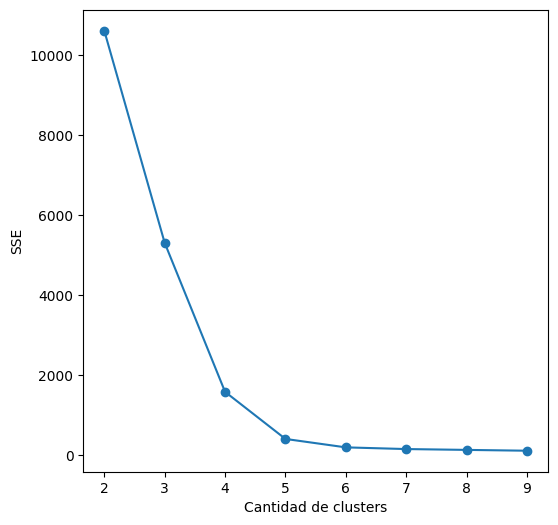

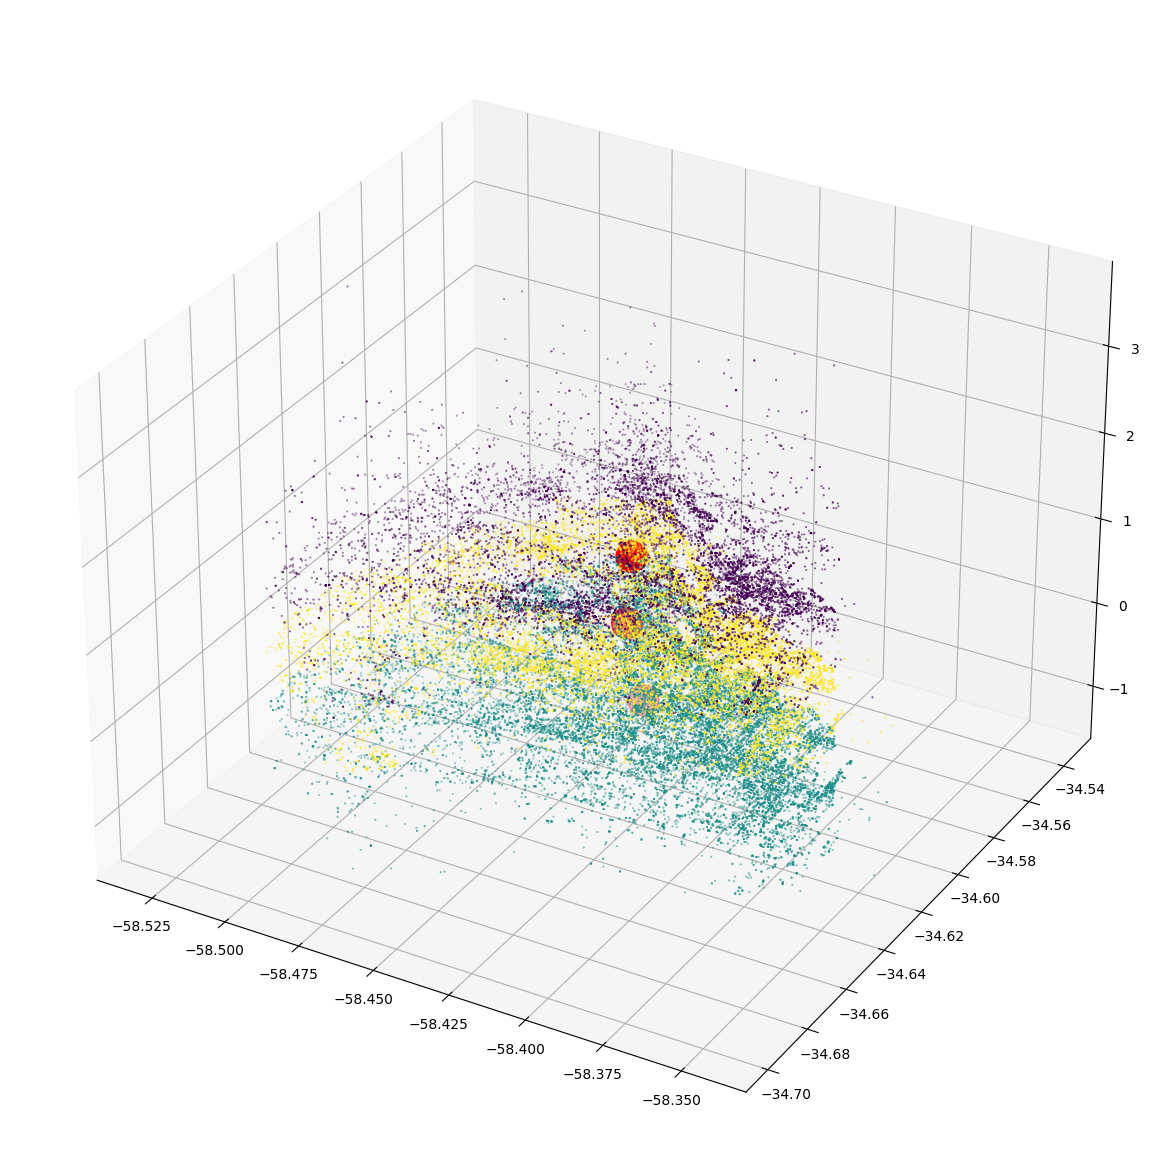

In [131]:
X = df.iloc[:,[5,4,15]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

centers = kmeans.cluster_centers_
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=0.2)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c="red", s=500, marker="o")

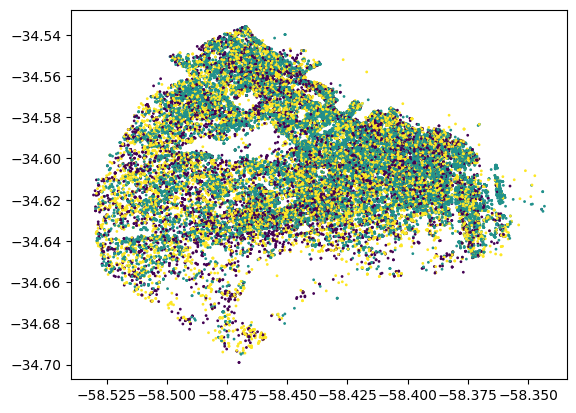

In [132]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=1)


Como no obtuvimos un clustering definido, buscamos ver si existía un agrupamiento entre ubicación geográfica y precio por metro cuadrado. Los resultados fueron similares.

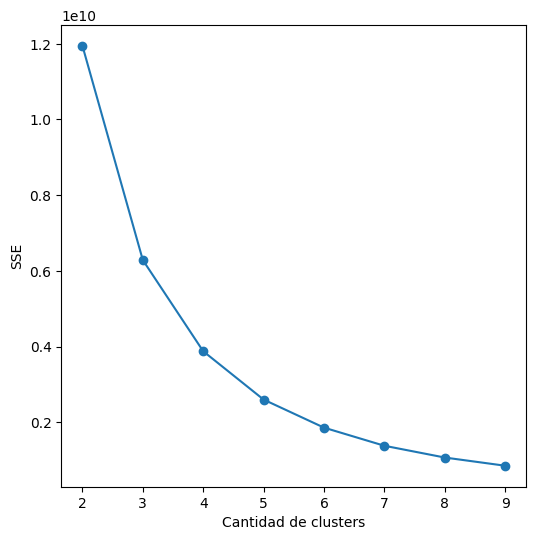

In [133]:
df["property_m2price"] = df["property_price"] / df["property_surface_total"]
X = df.iloc[:,[5,4, df.shape[1]-1]].loc[(df.property_m2price < 5000)].values
sse = []
sscore = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    y_kmeans = km.predict(X)
    sse.append(km.inertia_)
    sscore.append(silhouette_score(X, y_kmeans))
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

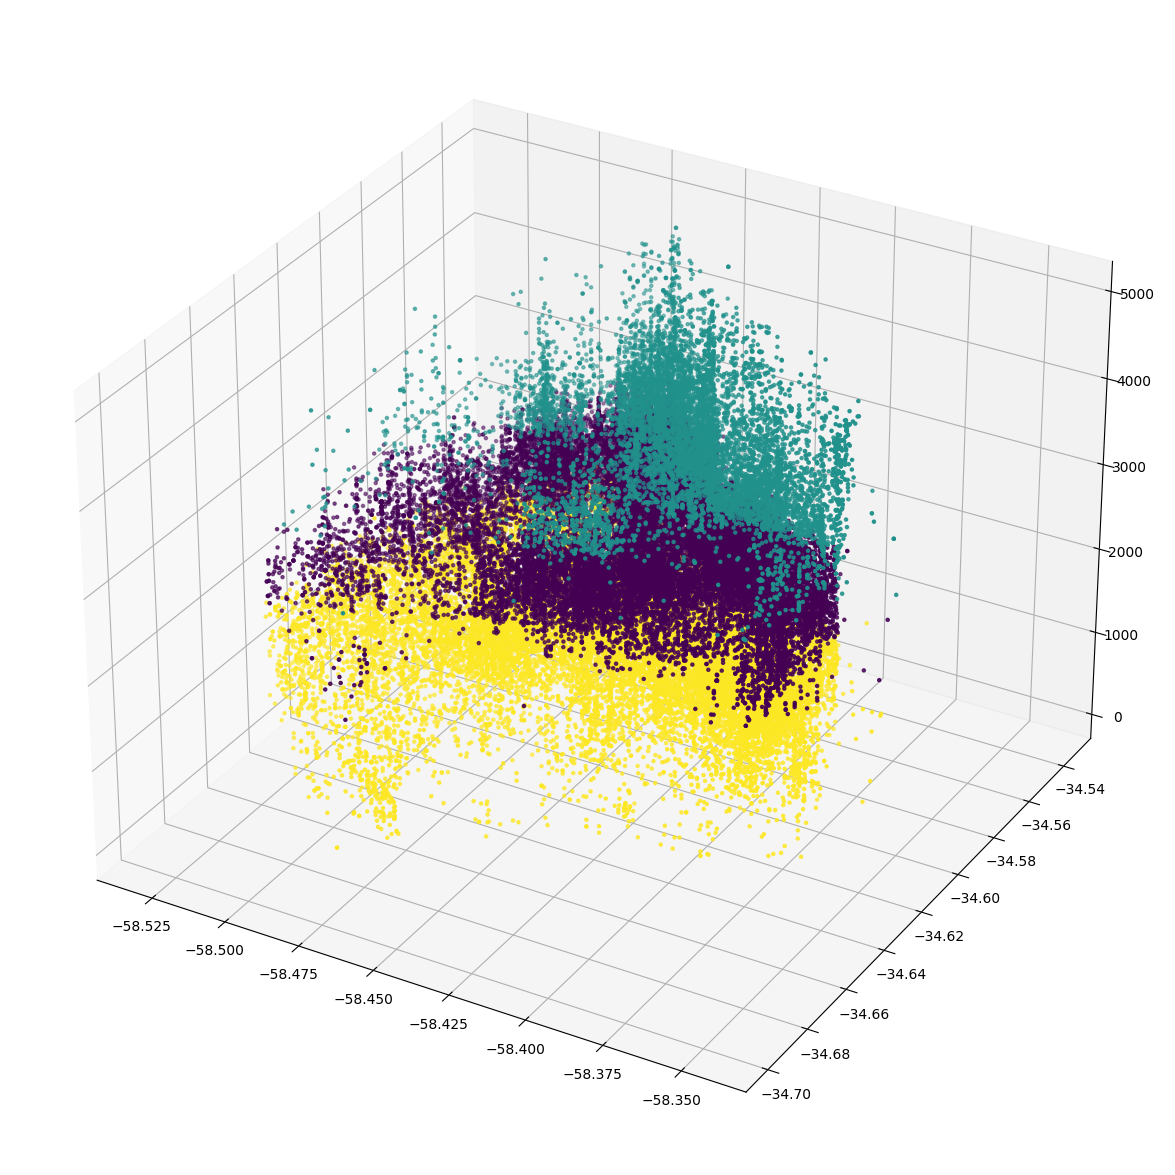

In [134]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=5)

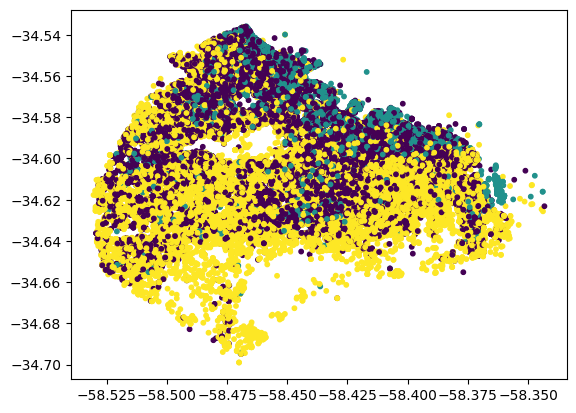

In [135]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)


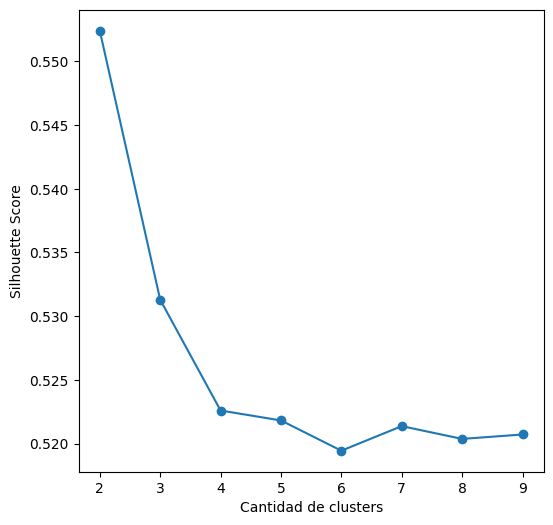

In [136]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sscore, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('Silhouette Score')
plt.show()

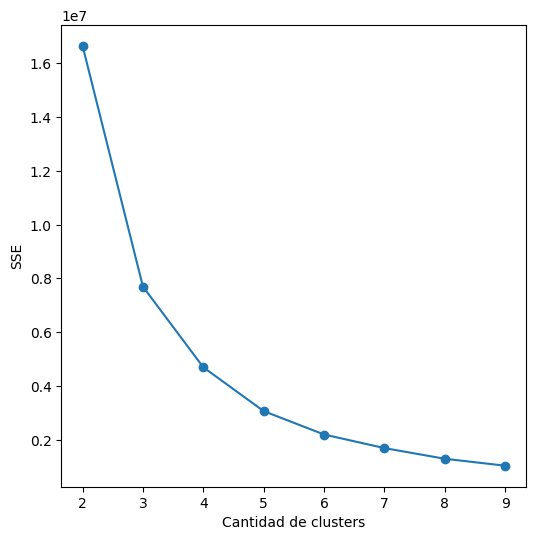

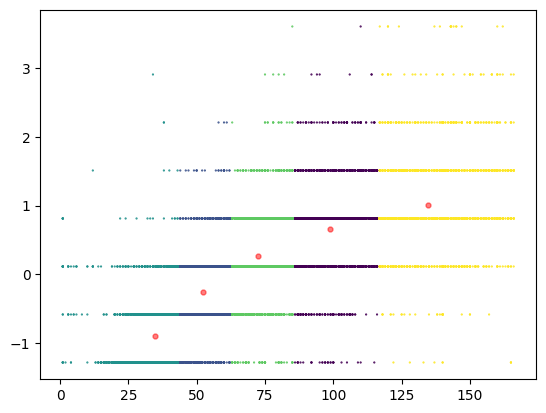

In [137]:
X = df.iloc[:,[15,13]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

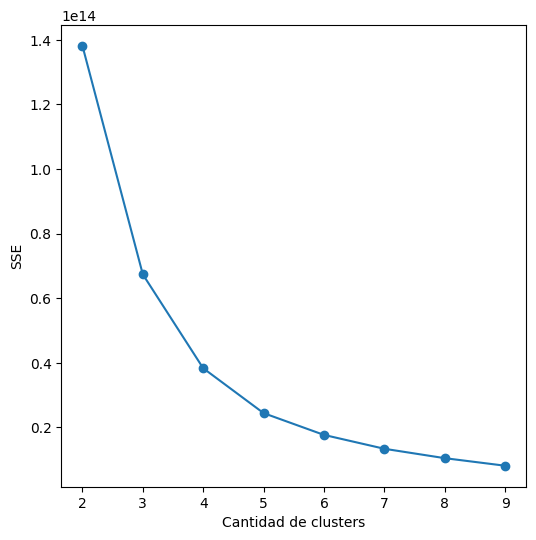

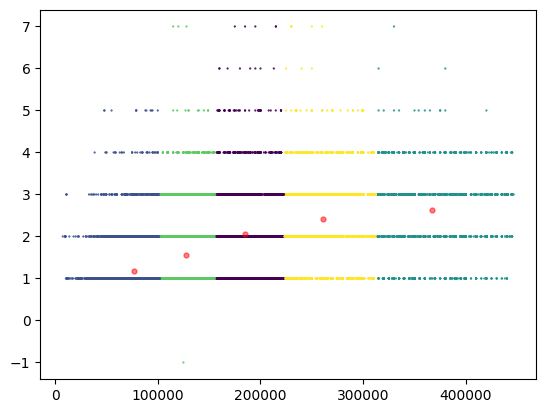

In [138]:
X = df.iloc[:,[11,14]].loc[df.property_rooms.notna()].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
   km = KMeans(n_clusters=k)
   km.fit(X)
   sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

#  **3. Clasificación**

## **3a. Construcción del target**

3.a.1 Primera alternativa, variable pxm2 en 3 intervalos con igual cantidad de observaciones

In [139]:
df.sort_values(by=["property_m2price"], inplace=True)

In [140]:
df['tipo_precio_1'] = pd.qcut(x=df['property_m2price'], q=3, labels=['bajo', 'medio', 'alto'])

3.a.2 Segunda alternativa, variable pxm2 en 3 intervalos, 25% a bajo, 50% a medio y el otro 25% restante a alto

In [141]:
df['tipo_precio_2'] = pd.qcut(x=df['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto'])
df['tipo_precio_2'].replace("medio2","medio", inplace=True)

3.a.3 Tercera alternativa, como el punto anterior pero separado por tipo de propiedad

In [142]:
df['tipo_precio_3'] = pd.qcut(x=df.loc[df['property_type'] == 'Departamento']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio")
df['tipo_precio_3'].fillna(pd.qcut(x=df.loc[df['property_type'] == 'Casa']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)
df['tipo_precio_3'].fillna(pd.qcut(x=df.loc[df['property_type'] == 'PH']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)

Analizamos las distribuciones del precio por metro cuadrado, el precio por metro cuadrado segun el tipo de propiedad y las distribuciones de los tipos de precio segun tipo de propiedad. Es importante notar que los gráficos estan en escala logarítmica ya que las cantidades tienen ordenes de magnitud muy distintos.

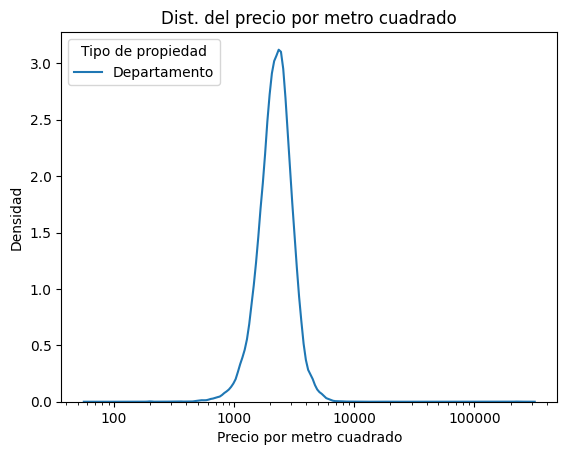

In [143]:
sns.kdeplot(data=df, x="property_m2price", log_scale=True).set(title='Dist. del precio por metro cuadrado')
plt.xlabel('Precio por metro cuadrado')
plt.ylabel('Densidad')
plt.legend(title='Tipo de propiedad', loc='upper left', labels=['Departamento', 'PH', 'Casa'])
ax=plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

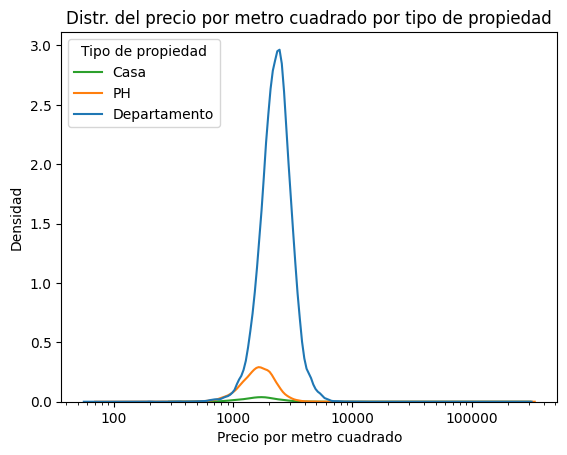

In [144]:
sns.kdeplot(data=df, x="property_m2price", hue="property_type", log_scale=True).set(title='Distr. del precio por metro cuadrado por tipo de propiedad')
plt.xlabel('Precio por metro cuadrado')
plt.ylabel('Densidad')
plt.legend(title='Tipo de propiedad', loc='upper left', labels=['Casa', 'PH', 'Departamento'])
ax=plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

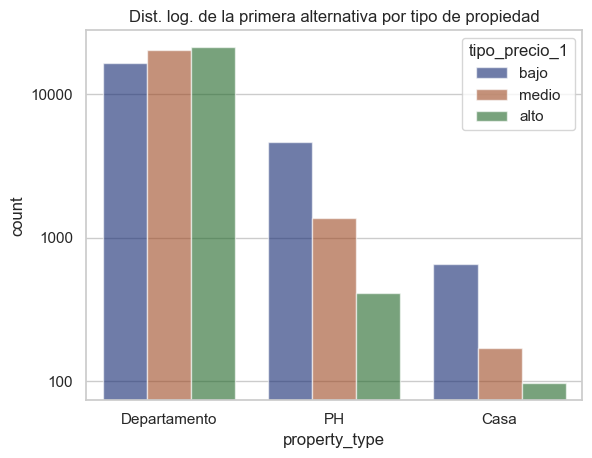

In [145]:
sns.set_theme(style="whitegrid")
sns.countplot(
    x='property_type',
    hue='tipo_precio_1',
    data=df,palette="dark",
    alpha=.6,
    log=True).set(title='Dist. log. de la primera alternativa por tipo de propiedad')
ax=plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

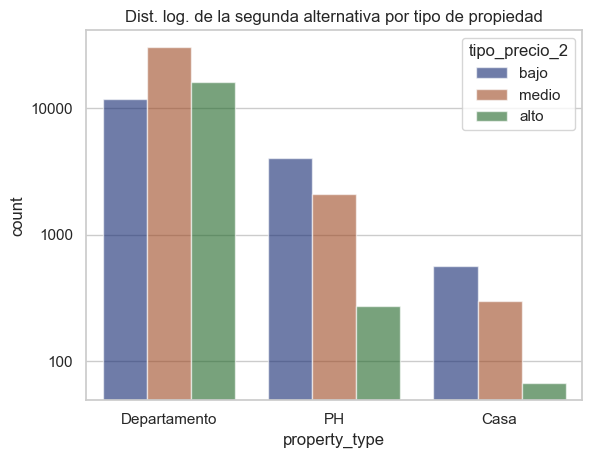

In [146]:
sns.countplot(
    x='property_type',
    hue='tipo_precio_2',
    data=df,palette="dark",
    alpha=.6,
    log=True).set(title='Dist. log. de la segunda alternativa por tipo de propiedad')
ax=plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

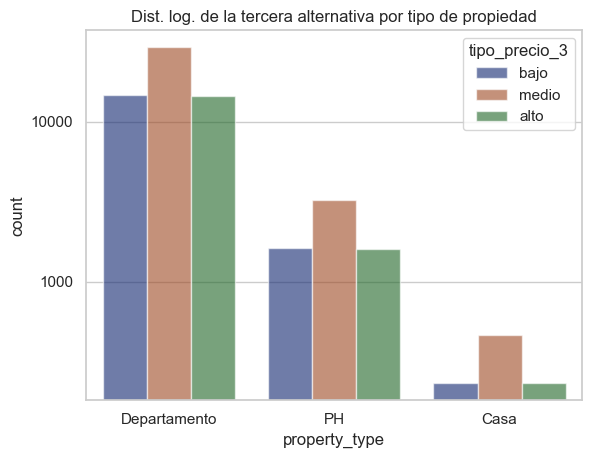

In [147]:
sns.countplot(
    x='property_type',
    hue='tipo_precio_3',
    data=df,palette="dark",
    alpha=.6,
    log=True).set(title='Dist. log. de la tercera alternativa por tipo de propiedad')
ax=plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

Analizando el gráfico "Distr. del precio por metro cuadrado por tipo de propiedad" podemos ver que la mediana del precio es distinta según el tipo de propiedad. Por este motivo decidimos que la mejor alternativa es la tercera, ya que separa las bandas de precio según el tipo de propiedad.

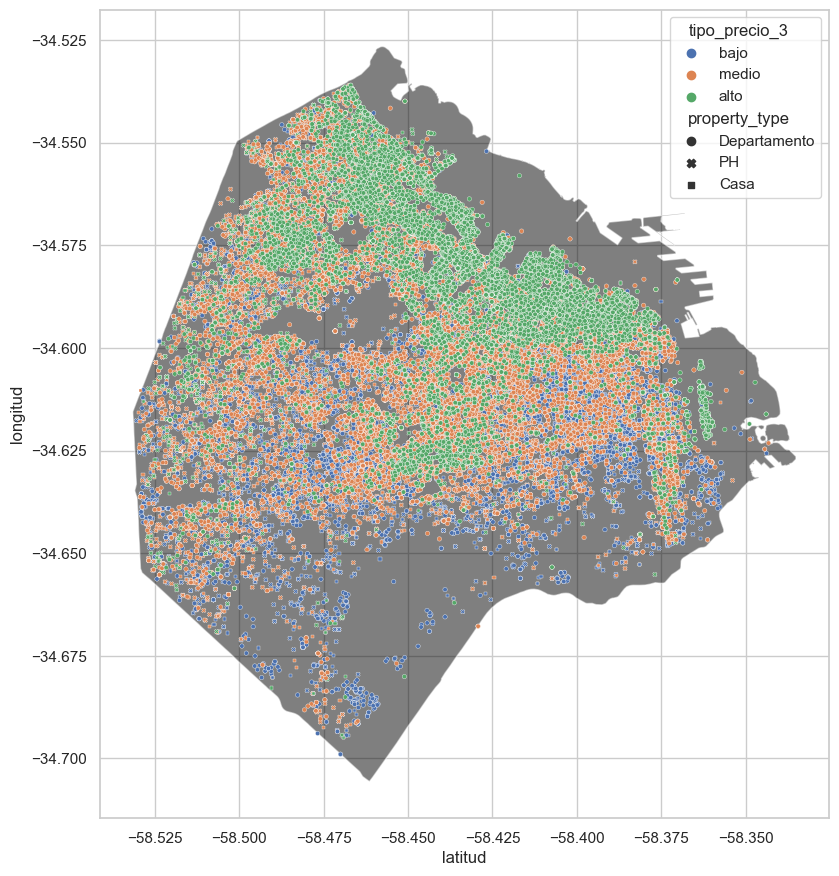

In [148]:
gpd.read_file('caba.geojson').plot(cmap='cubehelix', alpha=0.5)
sns.scatterplot(x="longitud", 
                y="latitud", 
                s=10,
                hue="tipo_precio_3",
                style="property_type",
                data=df,
                palette="deep")
plt.xlabel("latitud")
plt.ylabel("longitud")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Realizamos el agrupamiento por K-means

In [149]:
df_aux=df.loc[(df.property_m2price < 8000)]
X = df_aux.loc[:,["latitud","longitud", "property_m2price"]].values
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

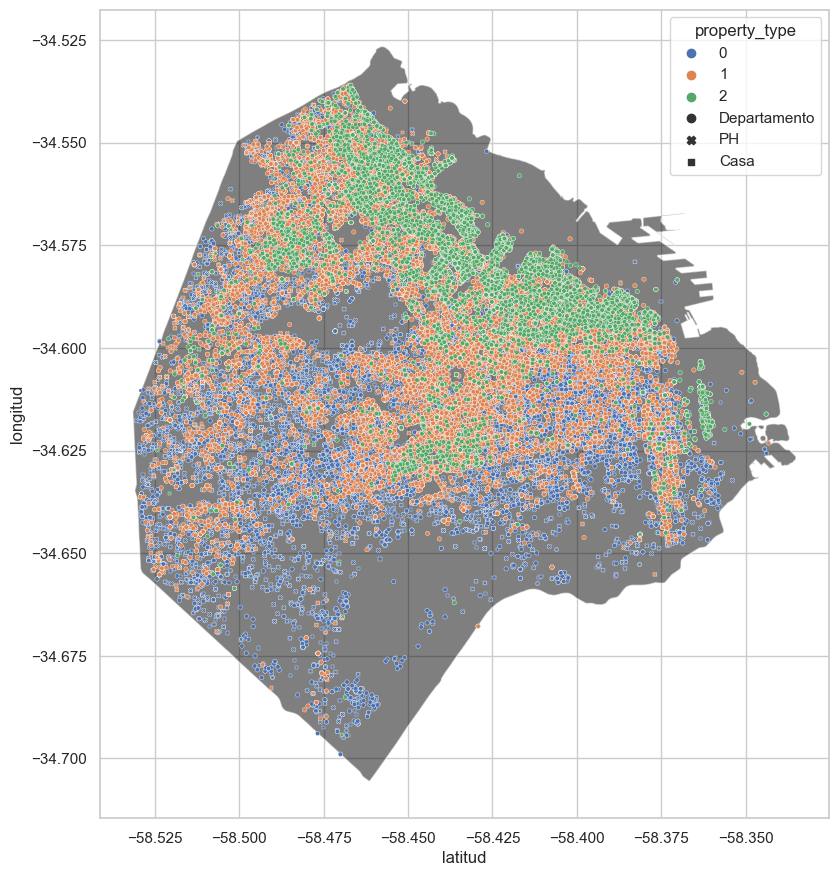

In [150]:
gpd.read_file('caba.geojson').plot(cmap='cubehelix', alpha=0.5)
sns.scatterplot(x="longitud", 
                y="latitud", 
                s=10,
                hue=y_kmeans,
                style="property_type",
                data=df_aux,
                palette="deep")
plt.xlabel("latitud")
plt.ylabel("longitud")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Observando los mapas resultantes, podemos ver que los dos tipos de agrupamientos dieron resultaros similares

## **3b. Entrenamiento y Predicción**

Primero creamos un dataset sin los features a predecir. También quitamos las columnas "place" superiores a l4, que tienen información repetida y las columnas de variables reducidasm que utilizaremos para otros modelos.

In [151]:
df.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l2', 'place_l3', 'place_l4', 'property_type', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price', 'z_rooms', 'zm_rooms',
       'z_bedrooms', 'zm_bedrooms', 'z_price', 'zm_price', 'z_surface_covered',
       'zm_surface_covered', 'z_surface_total', 'zm_surface_total',
       'property_m2price', 'tipo_precio_1', 'tipo_precio_2', 'tipo_precio_3'],
      dtype='object')

In [152]:
ds_trabajo_x=df.drop(['tipo_precio_1', 'tipo_precio_2', 'tipo_precio_3', 'z_price', 'zm_price', 'place_l2', 'place_l3', 'property_price', 'id', 'property_m2price','z_rooms','zm_rooms','z_bedrooms','zm_bedrooms','z_surface_covered','zm_surface_covered','z_surface_total',
    'zm_surface_total'], axis='columns')

Reemplazamos las fechas por valores numéricos

In [153]:
import math
import sys
max_end_date = max(ds_trabajo_x['end_date'])
ds_trabajo_x['start_date'] = ds_trabajo_x['start_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else max(df['start_date']))
ds_trabajo_x['end_date'] = ds_trabajo_x['end_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else max_end_date.toordinal())
ds_trabajo_x['created_on'] = ds_trabajo_x['created_on'].apply(lambda x: x.toordinal() if not pd.isna(x) else max(df['created_on']))

Creamos un dataframe para el entrenamiento con variables reducidas

In [154]:
from scipy.stats import zscore
numeric_cols = ds_trabajo_x.select_dtypes(include=[np.number]).columns # Solo en las de tipo numérico
ds_reducida_x = ds_trabajo_x[numeric_cols].apply(zscore)
ds_reducida_x['property_type'] = ds_trabajo_x['property_type'] 
ds_reducida_x['place_l4'] = ds_trabajo_x['place_l4'] 

Realizamos one hot encoding para las variables cualitativas

In [155]:
ds_trabajo_x = pd.get_dummies(ds_trabajo_x, columns=['place_l4', 'property_type'], drop_first=True)
ds_reducida_x = pd.get_dummies(ds_reducida_x, columns=['place_l4', 'property_type'], drop_first=True)

Luego creamos un dataset con la variable target

In [156]:
ds_trabajo_y = df['tipo_precio_3'].copy()

Separamos en conjuntos de test y train

In [157]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,
                                                    random_state=100)
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(ds_reducida_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.2,
                                                    random_state=100)

## Modelo 1: Arbol de Decisión

Primero entrenamos un arbol de decisión con las variables normales

In [158]:
param_grid = {
    'max_depth': [*range(18, 23, 1)],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00003,0.00004,0.00005, 0.00006,0.00007]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [3e-05, 4e-05, 5e-05, 6e-05, 7e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [18, 19, 20, 21, 22]})

In [159]:
grid.best_params_

{'ccp_alpha': 6e-05, 'criterion': 'gini', 'max_depth': 22}

In [160]:
y_pred = grid.predict(x_test)

Podemos ver los resultados con una matriz de confusión.
Orden: Alto, Bajo, Medio

Text(47.25, 0.5, 'True')

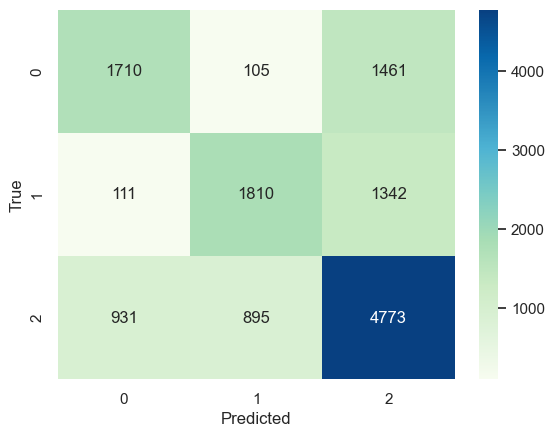

In [161]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [162]:
score_train = grid.score(x_train, y_train)
score_test = grid.score(x_test, y_test)
print('El Accuracy del modelo evaluando el set de train es: ', score_train, ' y el Accuracy del modelo evaluando el set de test es: ', score_test)

El Accuracy del modelo evaluando el set de train es:  0.7420361560418649  y el Accuracy del modelo evaluando el set de test es:  0.6312224082813214


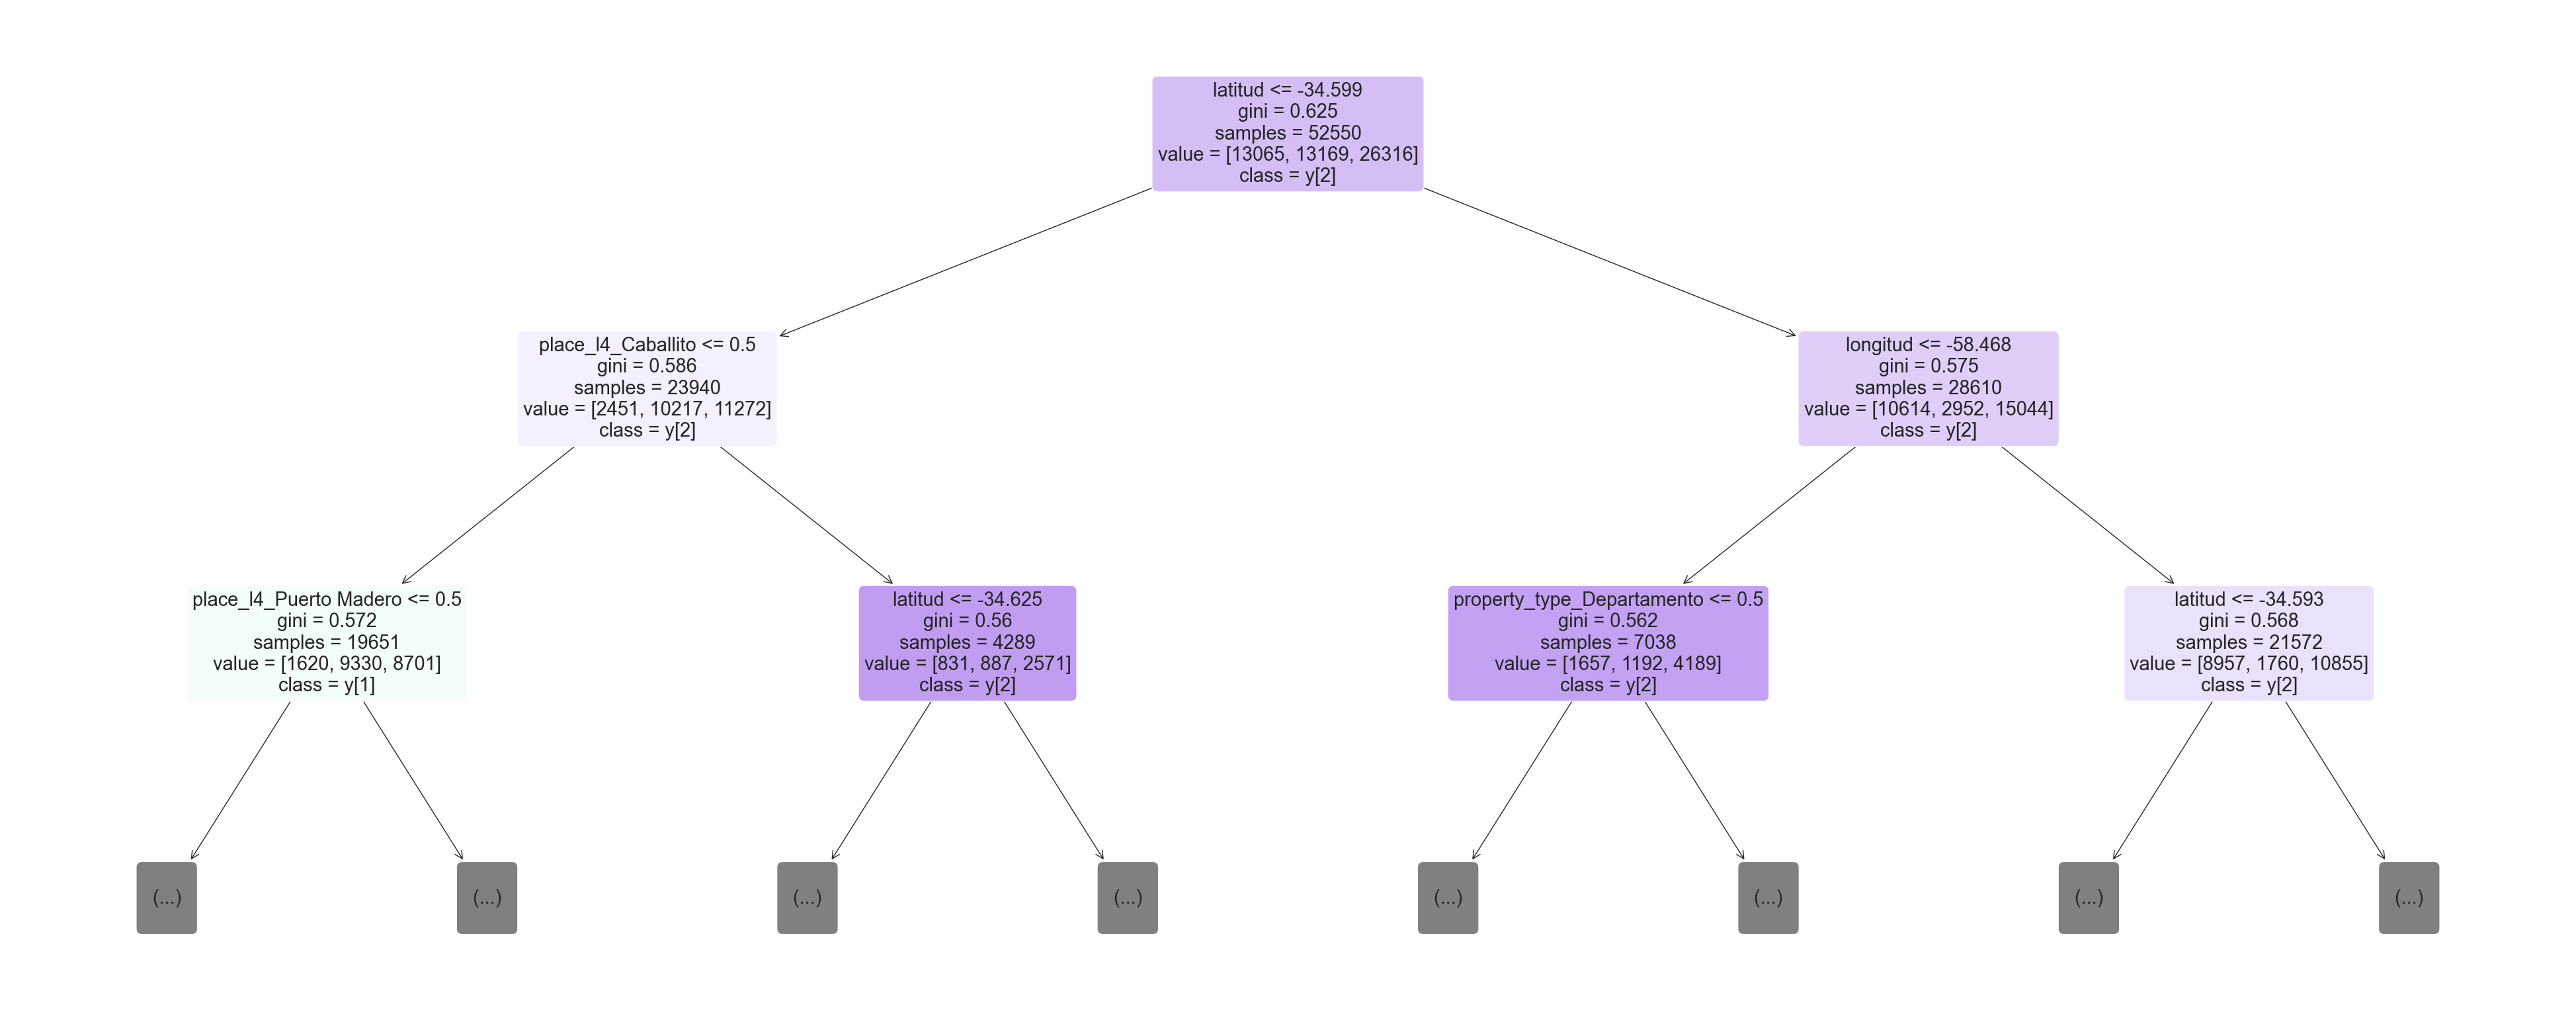

In [163]:
plt.figure(figsize=(50,20))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

Luego entrenamos un arbol de decisión con las variables reducidas

In [164]:
param_grid = {
    'max_depth': [*range(18, 23, 1)],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00003,0.00004,0.00005, 0.00006,0.00007]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train_red, y_train_red)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [3e-05, 4e-05, 5e-05, 6e-05, 7e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [18, 19, 20, 21, 22]})

In [165]:
grid.best_params_

{'ccp_alpha': 6e-05, 'criterion': 'gini', 'max_depth': 22}

In [166]:
y_pred = grid.predict(x_test_red)

Text(47.25, 0.5, 'True')

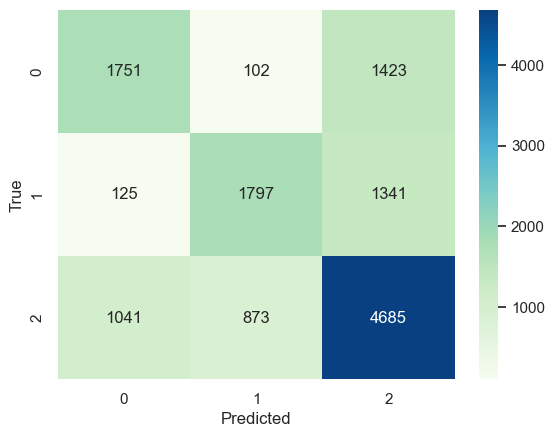

In [167]:
matrix=confusion_matrix(y_test_red, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [168]:
score_train = grid.score(x_train_red, y_train_red)
score_test = grid.score(x_test_red, y_test_red)
print('El Accuracy del modelo evaluando el set de train reducido es: ', score_train, ' y el Accuracy del modelo evaluando el set de test reducido es: ', score_test)

El Accuracy del modelo evaluando el set de train reducido es:  0.7453092293054234  y el Accuracy del modelo evaluando el set de test reducido es:  0.6266555031207185


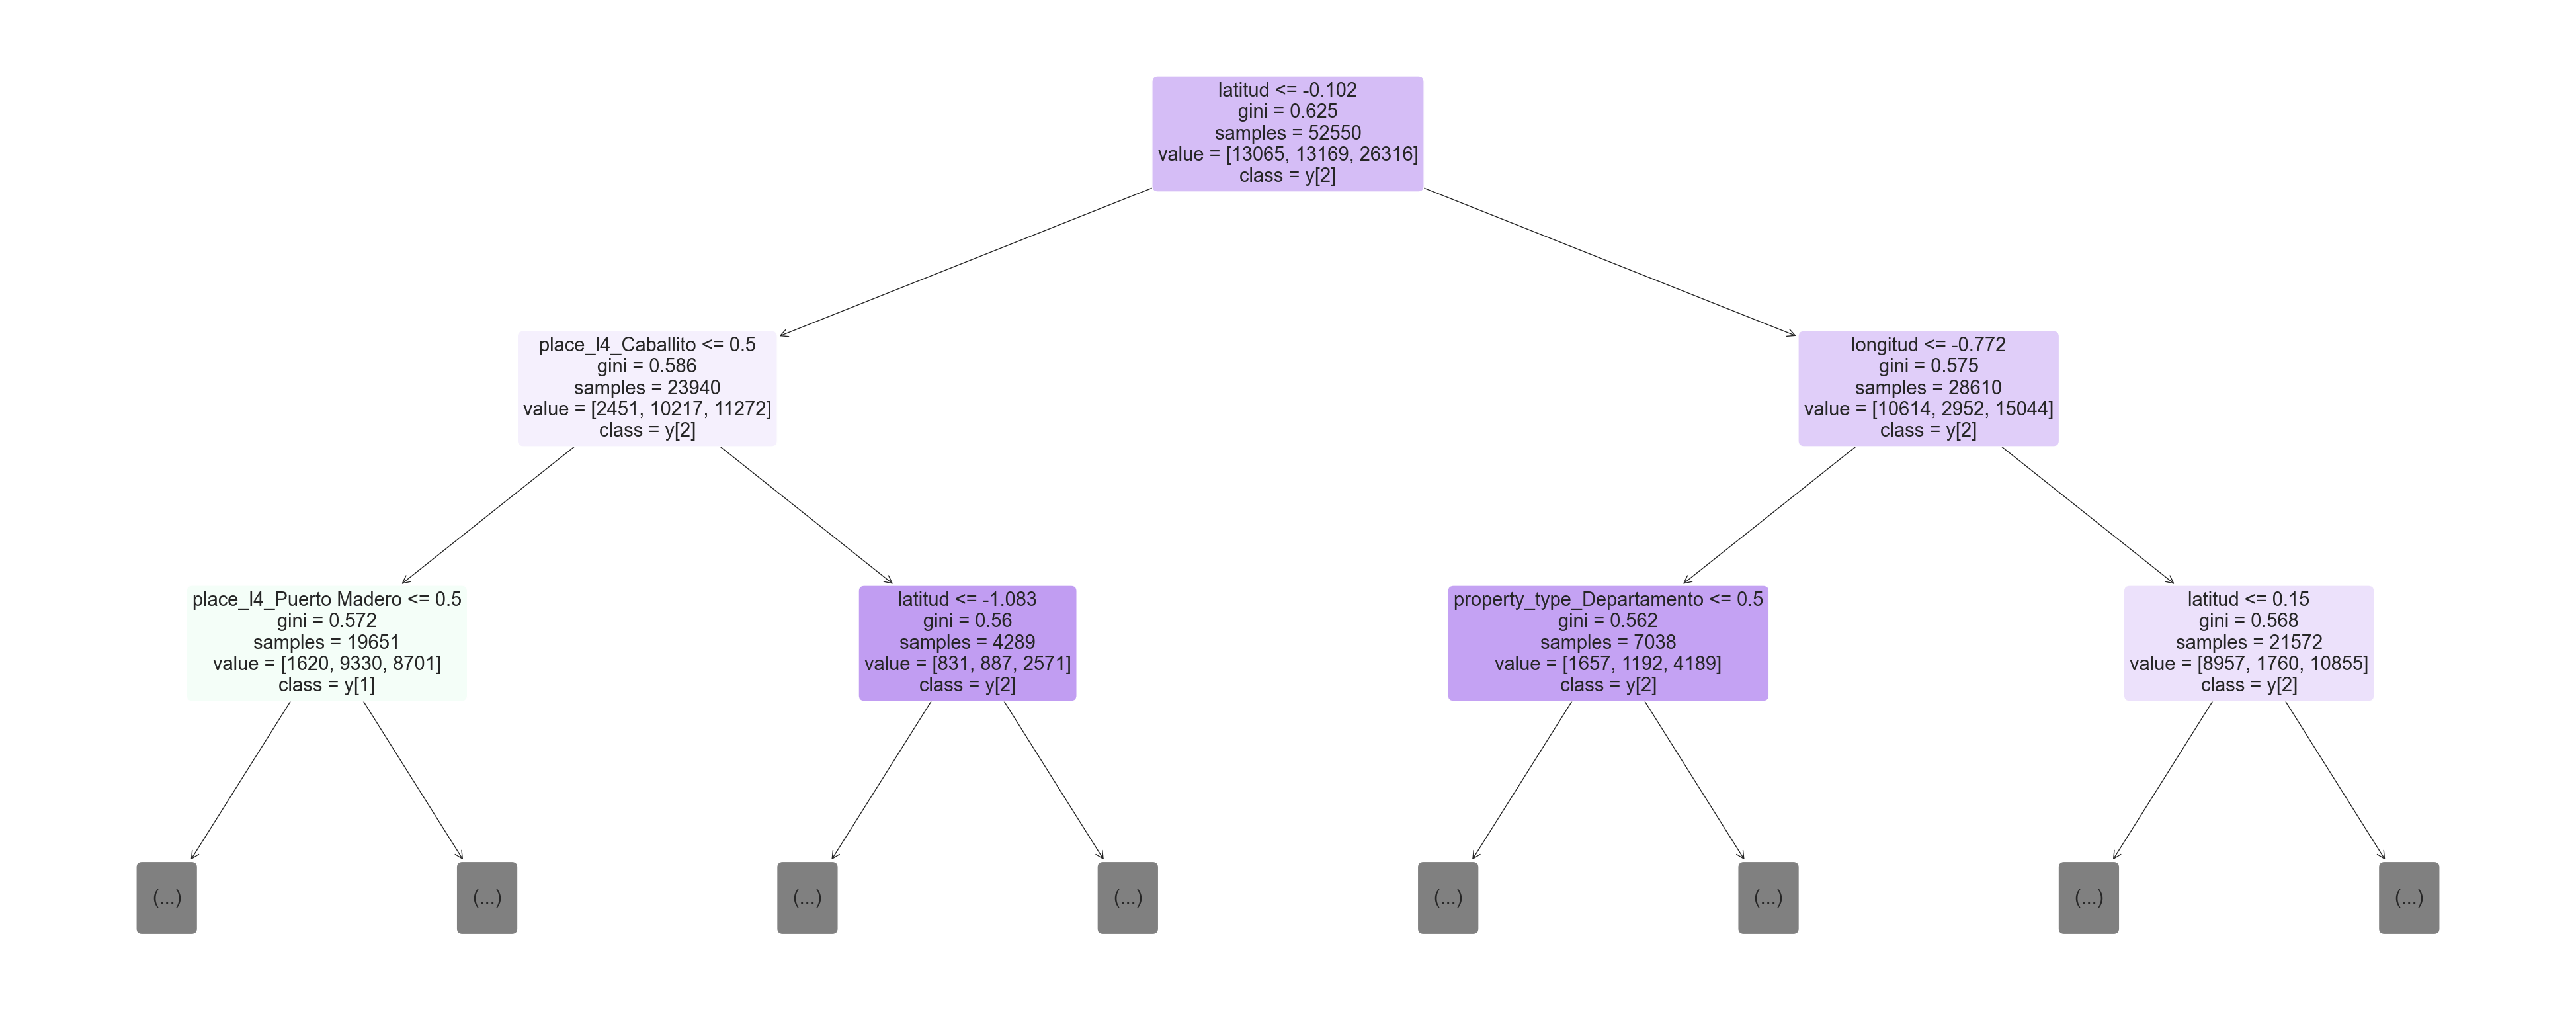

In [169]:
plt.figure(figsize=(50,20))

tree_plot=tree.plot_tree(grid.best_estimator_,
                         max_depth=2,
                         feature_names=ds_reducida_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

El modelo decide en base a la ubicación geográfica de la propiedad. En primer lugar verifica la latitud, separando CABA en Norte y Sur.

Para la parte Sur, verifica el barrio de Caballito. En caso negativo, verifica si el barrio es Puerto Madero ya que las propiedades suelen tener mayor valor. Si Caballito es afirmativo, vuelve a verificar por  latitud si se trata de la parte Sur del mismo.

Para la parte Norte de CABA, verifica la longitud para ver si se trata de la zona Este u Oeste. Para la zona Este, basa su decisión en la latitud, verificando si se trata de la parte Norte de la misma.
En el caso de la zona Oeste, verifica si la propiedad se trata de un departamento.

## Modelo 2: Random Forest

Primero entrenamos un modelo Random Forest de decisión con las variables normales

In [170]:
param_grid = {
    'n_estimators': [45, 55, 65],
    'max_depth': [23, 25, 27],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00002,0.000025]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [2e-05, 2.5e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [23, 25, 27],
                         'n_estimators': [45, 55, 65]})

In [171]:
grid.best_params_

{'ccp_alpha': 2e-05, 'criterion': 'gini', 'max_depth': 27, 'n_estimators': 65}

In [172]:
y_pred = grid.predict(x_test)

Podemos ver los resultados con una matriz de confusión.
Orden: Alto, Bajo, Medio

Text(47.25, 0.5, 'True')

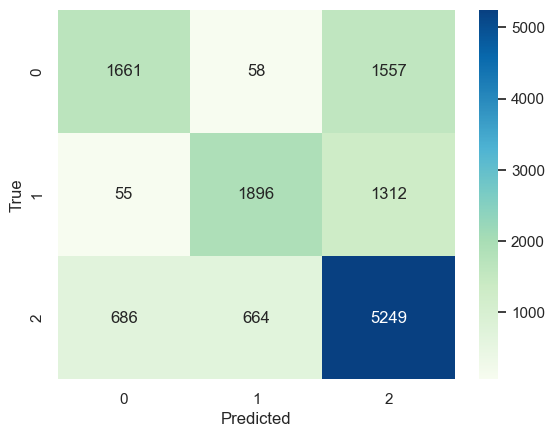

In [173]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [174]:
score_train = grid.score(x_train, y_train)
score_test = grid.score(x_test, y_test)
print('El Accuracy del modelo evaluando el set de train es: ', score_train, ' y el Accuracy del modelo evaluando el set de test es: ', score_test)

El Accuracy del modelo evaluando el set de train es:  0.9415413891531874  y el Accuracy del modelo evaluando el set de test es:  0.6702694474044756


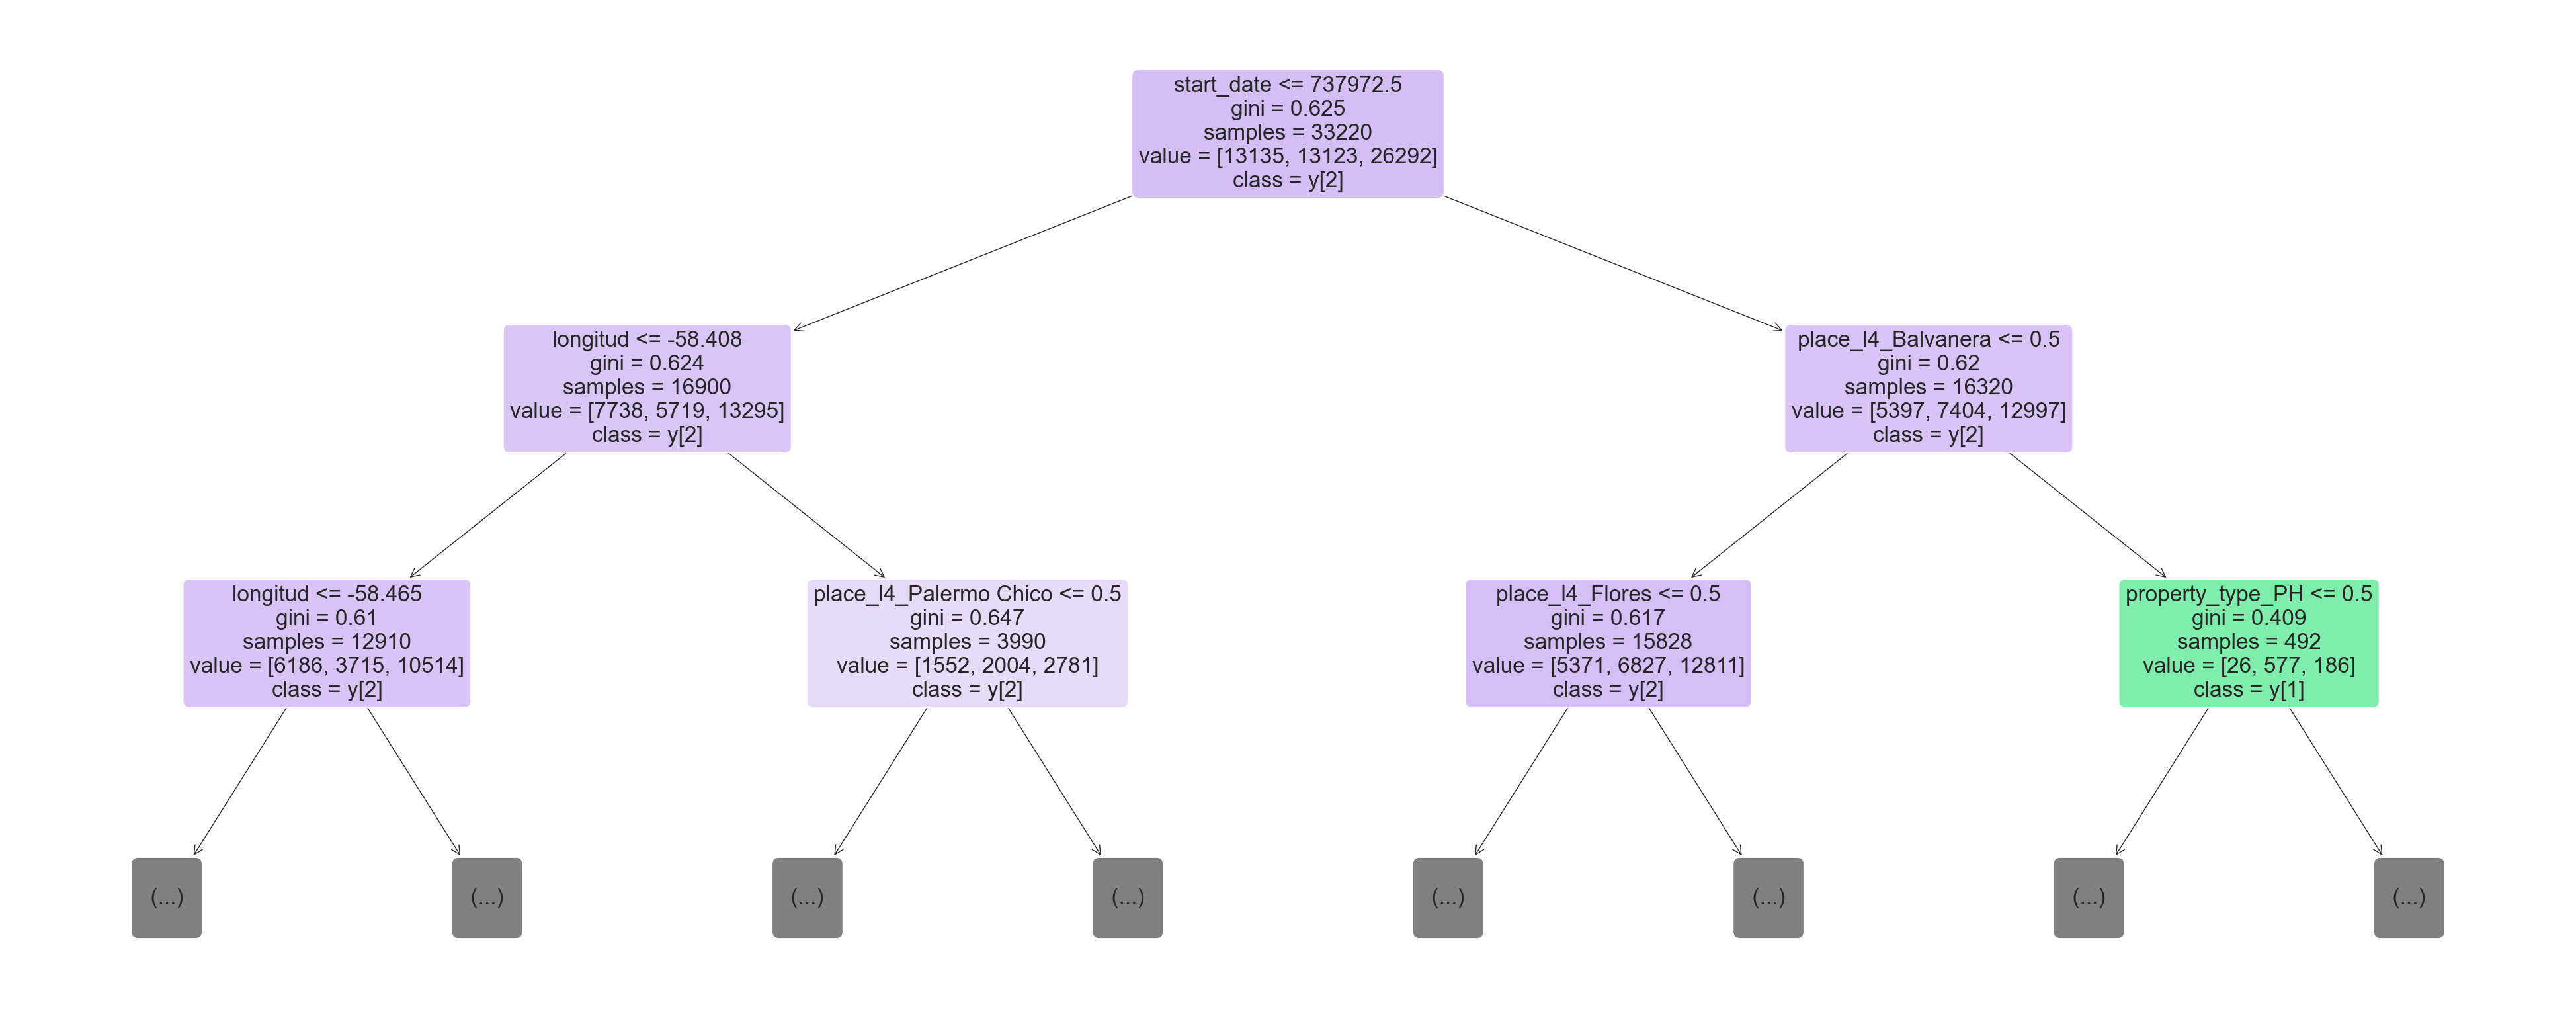

In [175]:
plt.figure(figsize=(50,20))
tree_plot=tree.plot_tree(grid.best_estimator_.estimators_[1],
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

Luego entrenamos un modelo Random Forest de decisión con las variables reducidas

In [176]:
param_grid = {
    'n_estimators': [40, 55],
    'max_depth': [23, 25],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.00002,0.000025]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train_red, y_train_red)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [2e-05, 2.5e-05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [23, 25], 'n_estimators': [40, 55]})

In [177]:
grid.best_params_

{'ccp_alpha': 2e-05,
 'criterion': 'entropy',
 'max_depth': 25,
 'n_estimators': 55}

In [178]:
y_pred = grid.predict(x_test_red)

Podemos ver los resultados con una matriz de confusión.
Orden: Alto, Bajo, Medio

Text(47.25, 0.5, 'True')

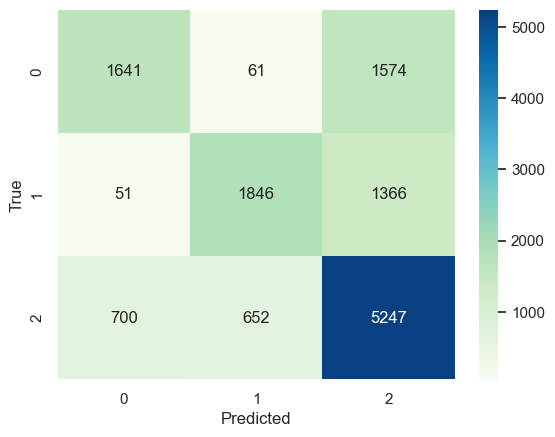

In [179]:
matrix=confusion_matrix(y_test_red, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [180]:
score_train = grid.score(x_train_red, y_train_red)
score_test = grid.score(x_test_red, y_test_red)
print('El Accuracy del modelo evaluando el set de train reducido es: ', score_train, ' y el Accuracy del modelo evaluando el set de test reducido es: ', score_test)

El Accuracy del modelo evaluando el set de train reducido es:  0.9490960989533778  y el Accuracy del modelo evaluando el set de test reducido es:  0.6647891612117521


## Método 3: KNN

Primero entrenamos un modelo K-nearest neighbours con las variables normales

In [181]:
param_grid = {
    'n_neighbors': [*range(5, 8, 1)],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_jobs':[-1],
    'leaf_size':[*range(18, 23, 2)]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [18, 20, 22], 'n_jobs': [-1],
                         'n_neighbors': [5, 6, 7],
                         'weights': ['uniform', 'distance']})

In [182]:
grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 18,
 'n_jobs': -1,
 'n_neighbors': 7,
 'weights': 'distance'}

In [183]:
y_pred = grid.predict(x_test)

pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

test   pred
0       alto   alto
1      medio  medio
2      medio  medio
3      medio  medio
4       alto  medio
...      ...    ...
13133  medio  medio
13134   bajo  medio
13135   alto   alto
13136   alto   alto
13137   alto  medio

[13138 rows x 2 columns]

Text(47.25, 0.5, 'True')

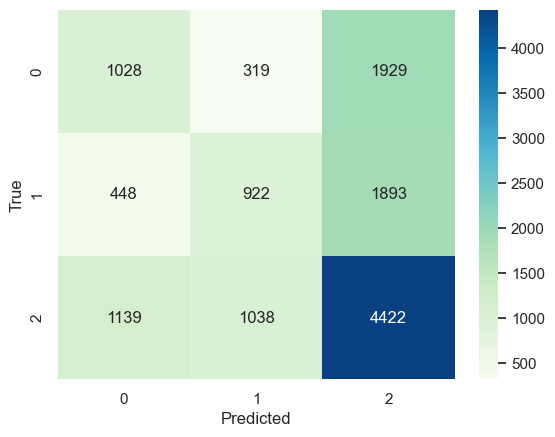

In [184]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [185]:
score_train = grid.score(x_train, y_train)
score_test = grid.score(x_test, y_test)
print('El Accuracy del modelo evaluando el set de train es: ', score_train, ' y el Accuracy del modelo evaluando el set de test es: ', score_test)

El Accuracy del modelo evaluando el set de train es:  0.9960989533777355  y el Accuracy del modelo evaluando el set de test es:  0.4850053280560207


Luego entrenamos un modelo K-nearest neighbours con las variables reducidas

In [186]:
param_grid = {
    'n_neighbors': [7, 8, 9],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['distance'],
    'n_jobs':[-1],
    'leaf_size':[20, 15, 10]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(x_train_red, y_train) 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree'], 'leaf_size': [20],
                         'n_jobs': [-1], 'n_neighbors': [7],
                         'weights': ['distance']})

In [187]:
grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'n_jobs': -1,
 'n_neighbors': 7,
 'weights': 'distance'}

In [188]:
y_pred = grid.predict(x_test_red)

pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])

test   pred
0       alto   alto
1      medio   alto
2      medio  medio
3      medio   alto
4       alto  medio
...      ...    ...
13133  medio  medio
13134   bajo  medio
13135   alto   alto
13136   alto  medio
13137   alto  medio

[13138 rows x 2 columns]

Text(47.25, 0.5, 'True')

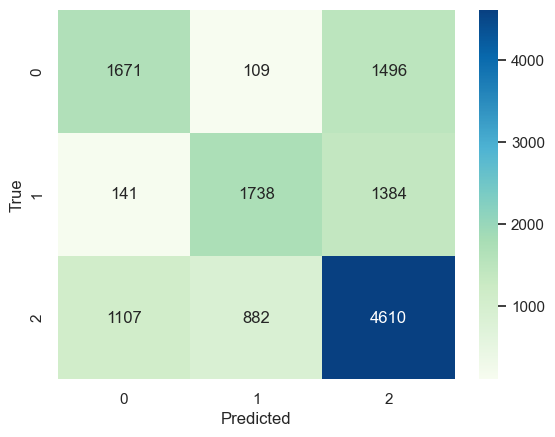

In [189]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [190]:
score_train = grid.score(x_train_red, y_train_red)
score_test = grid.score(x_test_red, y_test_red)
print('El Accuracy del modelo evaluando el set de train reducido es: ', score_train, ' y el Accuracy del modelo evaluando el set de test reducido es: ', score_test)

El Accuracy del modelo evaluando el set de train reducido es:  0.9961179828734539  y el Accuracy del modelo evaluando el set de test reducido es:  0.6103668747145684


#  **4. Regresión**

En esta última parte del trabajo, buscaremos predecir el precio de la propiedad (variable property_price) utilizando los modelos

- KNN
- XGBoost
- Adaboost

Trabajaremos tanto con el data set de train (df), como con el resultante del item 1d (df_reduc). Como se menciono previamente, las tareas de ingenieria de caracteristicas ya fueron realizadas previamente.

## Modelo KNN

In [211]:
df_knn = df.copy()

In [241]:
df_knn.iloc[:,0:15]

id start_date   end_date created_on    latitud  \
92828   1gMQ4rXcpnPs+hhvW11Jdw== 2021-08-03 2021-10-28 2021-08-03 -34.622385   
266756  ZYkS+4dCz1vUENzAREcX9w== 2021-09-02 2021-09-02 2021-09-02 -34.601159   
454638  UL/s8zoicLDXXwhaelBgFQ== 2021-12-16 2022-02-09 2021-12-16 -34.605542   
409114  wnz+hkCE7RVBNcqDQEtFSw== 2021-03-19 2021-06-05 2021-03-19 -34.593266   
241652  +QvrIZqpMPRxlz+ilj1LkA== 2021-04-01 2021-06-24 2021-04-01 -34.564779   
...                          ...        ...        ...        ...        ...   
39842   CIrzzz0KQkUDDmjnFINLwA== 2021-07-30 2022-02-06 2021-07-30 -34.597304   
137036  i5lDg1C7ZEZyETXxCbolhw== 2021-01-22 2021-06-30 2021-01-22 -34.581910   
194451  b97ekVIR18ZDn3ZsDXWrVQ== 2021-11-02 2022-01-27 2021-11-02 -34.604510   
33600   7oLMN+ZSoOP2N9Uu7Pz68A== 2021-02-08 2021-03-07 2021-02-08 -34.657111   
299724  Wp8gte38mWUKv35WKMVs2g== 2021-01-18 2021-12-02 2021-01-18 -34.580785   

         longitud         place_l2       place_l3           place_l4  \
92828  -58.448886  Capital Federal      Caballito          Caballito   
266756 -58.398106  Capital Federal      Balvanera          Balvanera   
454638 -58.390007  Capital Federal    San Nicolás        San Nicolás   
409114 -58.381426  Capital Federal         Retiro             Retiro   
241652 -58.505463  Capital Federal  Villa Urquiza      Villa Urquiza   
...           ...              ...            ...                ...   
39842  -58.432406  Capital Federal   Villa Crespo       Villa Crespo   
137036 -58.449381  Capital Federal        Palermo            Palermo   
194451 -58.390908  Capital Federal   Villa Crespo       Villa Crespo   
33600  -58.405545  Capital Federal        Pompeya            Pompeya   
299724 -58.431046  Capital Federal        Palermo  Palermo Hollywood   

       property_type  property_rooms  property_bedrooms  \
92828   Departamento             4.0                3.0   
266756  Departamento             1.0                1.0   
454638  Departamento             1.0                1.0   
409114  Departamento             1.0                1.0   
241652            PH             6.0                3.0   
...              ...             ...                ...   
39842   Departamento             1.0                1.0   
137036  Departamento             2.0                1.0   
194451  Departamento             3.0                2.0   
33600   Departamento             4.0                3.0   
299724  Departamento             1.0                1.0   

        property_surface_total  property_surface_covered  property_price  
92828                    113.0                      97.0        288000.0  
266756                    33.0                      30.0         77243.0  
454638                    30.0                      30.0         65000.0  
409114                    40.0                      40.0         79000.0  
241652                   184.0                     124.0        350000.0  
...                        ...                       ...             ...  
39842                     29.0                      29.0         64500.0  
137036                    56.0                      52.0        144870.0  
194451                    64.0                      64.0        110000.0  
33600                     81.0                      75.0         73000.0  
299724                    36.0                      36.0         89900.0  

[65880 rows x 15 columns]

### Analisis de correlación

Para tomar un indicio inicial, procedemos a analizar el grafico de a pares entre todas las variables de nuestro data set inicial.



Sospechamos que las variables **property_surface_covered** y **property_surface_total** pueden llegar a tener cierta correlacion con el precio de la propiedad. 

Decidimos eliminar el ruido reduciendo la cantidad de registros del grafico, para poder verificar la suposición. De esta forma comprobamos que hay una clara correlacion con estas variables y en base a esto seran tenidas en cuenta en los analisis de los modelos.

A continuación vamos a analizar la correlación a traves de un Heatmap. Nuevamente notamos que en las partes mas coloradas del grafico se encuentran las variables previamente mencionadas.

In [195]:
df_knn.iloc[:,0:15].corr().style.background_gradient(cmap='coolwarm')

### Entrenamiento y Predicción

Como se estudió en la sección anterior, vamos a tener en cuenta las variables **property_surface_total** y **property_surface_covered** para realizar las predicciones, estableciendo una relación del 80% para el conjunto train y el restante para el test. 

In [196]:
x = df_knn[['property_surface_total', 'property_surface_covered']]
y = df_knn.property_price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=12)

A continuación mostramos los graficos en los cuales nos basamos, de forma mas detallada.

<AxesSubplot: xlabel='property_surface_total', ylabel='property_price'>

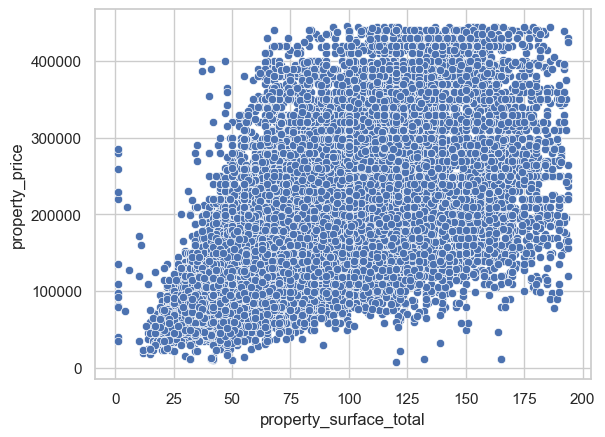

In [197]:
sns.scatterplot(x=x_train.property_surface_total,y=y_train)

<AxesSubplot: xlabel='property_surface_covered', ylabel='property_price'>

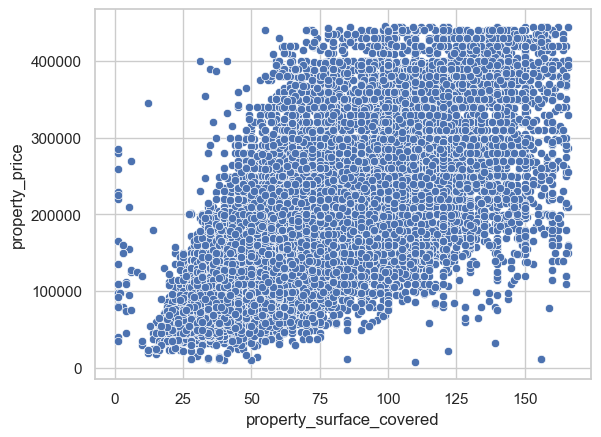

In [198]:
sns.scatterplot(x=x_train.property_surface_covered,y=y_train)

A continuación crearemos un modelo, y realizaremos una predicción sobre el mismo utilizando el data set de test.

In [200]:
knn_regressor = KNeighborsRegressor().fit(x_train, y_train)
y_pred=knn_regressor.predict(x_test)

print(f"La predicción obtenida es: {y_pred}")

La predicción obtenida es: [135740.  128106.  252517.6 ... 223000.   91800.  103580. ]


### Optimización de hiperparámetros

Observemos cuales son los parámetros por default que esta teniendo nuestro modelo.

In [201]:
knn_regressor.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

En base al entrenamiento y predicciones hechos en las celdas anteriores, notaremos la cantidad de aciertos obtenidos.

In [202]:
print("Se obtuvo un total de", np.sum(y_test == y_pred), "aciertos, sobre un total de", len(y_test))

Se obtuvo un total de 23 aciertos, sobre un total de 13138


Veamos que sucede si optimizamos estos parámetros. Recordemos que los que podremos setear serán **n_neighbors**, **algorithm**, **metric** y **weights**.

In [203]:
from sklearn.model_selection import RandomizedSearchCV

params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

Obtuvimos los siguientes resultados

In [204]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(knn_regressor, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.58


### Análisis de performance y Métricas

Estudiamos la matriz de confusión observando la densidad de las variables en donde acertamos nuestras predicciones.

A continuación observaremos cual es la performance lograda con el modelo actual. En la siguiente tabla podremos observar para algunos registros una comparación entre su valor real y el resultado de la predicción realizada. De igual manera se calcula el error entre los mismos.

In [205]:
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
performance.head()

Valor Real  Prediccion    Error
208379    125000.0    135740.0 -10740.0
437933    165000.0    128106.0  36894.0
105569    258000.0    252517.6   5482.4
98999      83900.0     71866.6  12033.4
422082    105800.0     83320.0  22480.0

Se detallan los valores obtenidos a través las métricas realizadas:

#### Mean Square Error

Esta métrica se encarga de para cada punto, calcular la diferencia cuadrada entre las predicciones y el objetivo. Luego de esto promedia esos valores. 

Lo que buscamos es que estos sean lo mas chico posibles, ya que cuanto mayor peor es el modelo.

In [206]:
from sklearn import metrics

mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

El error según la métrica 'Mean Square Error' de test es: 2839850350.967898


#### Root Mean Square Error

La diferencia con la métrica anterior es que esta es la raíz cuadrada de MSE. Lo que buscamos con esto es hacer que la escala de errores sea igual a la de los objetivos.

In [207]:
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

El error según la métrica 'Root Mean Square Error' de test es: 53290.24630237599


#### Coeficiente de determinación R2

Lo que hace esta métrica es liberarse de la escala que poseen los valores, ya que siempre se va a encontrar entre menos infinito y 1.

In [208]:
score_knn = knn_regressor.score(x_test, y_test)

print(f"El coeficiente de 'determinación' es: {score_knn}")

El coeficiente de 'determinación' es: 0.5906541281634077


## Modelo XGBoost

### Entrenamiento y prediccion

In [209]:
df_xgb = df.copy()

In [214]:
df_xgb.rename(columns={'property_price':'target'}, inplace=True)
df_xgb.target.value_counts(normalize=True)

110000.0    0.018146
85000.0     0.017598
120000.0    0.017218
125000.0    0.016822
115000.0    0.016609
              ...   
111549.0    0.000015
291785.0    0.000015
182429.0    0.000015
214899.0    0.000015
80200.0     0.000015
Name: target, Length: 3668, dtype: float64

In [215]:
features=list(df_xgb.columns[10:14])
print(features)

['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered']


In [216]:
x_train, x_test, y_train, y_test = train_test_split(df_xgb[features].values, 
                                                    df_xgb['target'].values, 
                                                    test_size=0.2,
                                                    random_state=13)

In [217]:
xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [218]:
from sklearn.model_selection import cross_val_score, KFold


### Optimizacion de hiperparametros

In [219]:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [220]:
print("Se obtuvo un total de", np.sum(y_test == y_pred), "aciertos, sobre un total de", len(y_test))

Se obtuvo un total de 3 aciertos, sobre un total de 13138


In [221]:
from sklearn.model_selection import RandomizedSearchCV

params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

In [222]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.65


### Análisis de performance y métricas

In [223]:
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
performance.head()

Valor Real  Prediccion     Error
0    168000.0    135740.0   32260.0
1     88000.0    128106.0  -40106.0
2     87000.0    252517.6 -165517.6
3     76000.0     71866.6    4133.4
4     72000.0     83320.0  -11320.0

#### Mean Square Error

In [224]:
from sklearn import metrics

mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

El error según la métrica 'Mean Square Error' de test es: 11636484606.030403


#### Root Mean Square Error

In [225]:
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

El error según la métrica 'Root Mean Square Error' de test es: 107872.53870207377


#### Coeficiente de determinación R2

Lo que hace esta métrica es liberarse de la escala que poseen los valores, ya que siempre se va a encontrar entre menos infinito y 1.

In [226]:
score = xgb_model.score(x_test, y_test)

print(f"El coeficiente de 'determinación' es: {score}")

El coeficiente de 'determinación' es: 0.6525970186083535


## Modelo Adaboost

### Entrenamiento y predicción

In [227]:
df_adb = df.copy()

In [228]:
df_adb.rename(columns={'property_price':'target'}, inplace=True)
df_adb.target.value_counts(normalize=True)

110000.0    0.018146
85000.0     0.017598
120000.0    0.017218
125000.0    0.016822
115000.0    0.016609
              ...   
111549.0    0.000015
291785.0    0.000015
182429.0    0.000015
214899.0    0.000015
80200.0     0.000015
Name: target, Length: 3668, dtype: float64

In [229]:
features=list(df_adb.columns[10:14])
print(features)

['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered']


In [230]:
x_train, x_test, y_train, y_test = train_test_split(df_adb[features].values, 
                                                    df_adb['target'].values, 
                                                    test_size=0.2,
                                                    random_state=13)

In [231]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=100)

In [232]:
ada_reg.fit(x_train, y_train)

AdaBoostRegressor(n_estimators=100)

### Optimización de hiperparametros

In [233]:
ada_reg.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 100,
 'random_state': None}

In [234]:
print("Se obtuvo un total de", np.sum(y_test == y_pred), "aciertos, sobre un total de", len(y_test))

Se obtuvo un total de 3 aciertos, sobre un total de 13138


In [235]:
from sklearn.model_selection import RandomizedSearchCV

params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

### Análisis de performance y métricas

In [236]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(ada_reg, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.57


In [237]:
from sklearn.metrics import mean_squared_error


#### Mean Square Error

In [238]:
from sklearn import metrics

mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

El error según la métrica 'Mean Square Error' de test es: 11636484606.030403


#### Root Mean Square Error

In [239]:
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

El error según la métrica 'Root Mean Square Error' de test es: 107872.53870207377


#### Coeficiente de determinación R2

Lo que hace esta métrica es liberarse de la escala que poseen los valores, ya que siempre se va a encontrar entre menos infinito y 1.

In [240]:
score = xgb_model.score(x_test, y_test)

print(f"El coeficiente de 'determinación' es: {score}")

El coeficiente de 'determinación' es: 0.6525970186083535


#  **5. Conclusiones**

Para finalizar el informe, haremos un pequeño repaso sobre todos los puntos que analizamos y sus respectivos resultados y/o observaciones hechos por nosotros:
	
Con respecto a los outliers obtenidos a lo largo del trabajo, pudimos observar que contamos con una mayor certeza de determinación de los mismos al realizar análisis multivariados, dado que se cuenta con más datos del entorno. Estos valores atípicos fueron analizados a través de diferentes métodos y en su mayoría posteriormente descartados del dataset.

Por otro lado, uno de los puntos a destacar dentro de los modelos de clasificación fue la diferencia en el score entre el entrenamiento con las variables normales y reducidas en el modelo KNN. Hubo un mejoramiento notable entre ambas predicciones. Posiblemente esto sea porque al calcular las distancias entre vecinos es importante que todas las variables esten en órdenes de magnitud similares.

Otro punto interesante fue la similitud entre la clasificación que obtuvimos por árbol de decisión comparándola con el agrupamiento por K-means. Se encontró que se formaron tres grupos similares, distribuidos aproximadamente por las mismas zonas. Además, el modelo de árbol de decisión fue el más fácil de analizar gráficamente.

Para la parte de regresión estuvimos estudiando 3 modelos. Por un lado utilizamos KNN. Si bien este modelo resulta el más sencillo de todos, suele ser el que peores predicciones realiza. Pasando al XGBoost, a pesar de que obtuvimos una menor cantidad de aciertos, el porcentaje obtenido mediante kfold fue superior. Utilizando el último modelo no notamos grandes variaciones en las métricas percibidas. Cabe destacar que en los tres obtuvimos errores entre las mediciones que son extremadamente altos. Esto nos llamó mucho la atención, y lo atribuímos a algún error cometido involuntariamente durante algún procesamiento.  

A lo largo de este trabajo práctico, logramos tener un primer acercamiento con estas tareas del análisis de datos. En particular, debimos tomar muchas decisiones cuyo impacto es difícil de estimar en el resultado final. Un ejemplo de ello fue la complejidad de decidir sobre el reemplazo de valores nulos en el dataset original de manera que no afecte la distribución natural de los datos. Concluimos, entonces, que el análisis de datos es una tarea compleja y para hacerlo de manera eficiente se tienen que realizar diversos y detallados análisis de todas las variables comprometidas.

